In [2]:
import os, sys

import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.patches import Rectangle

import importlib
import plot_utils 
importlib.reload(plot_utils)
from plot_utils import *

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'mathtext.default': 'regular'})
plt.rcParams['text.usetex'] = False

from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as patches

# Prepare the data

In [4]:
data_path = "../processed_data"

hcf_dfs        = []
ber_dfs        = []
ftber_dfs      = []
min_tAggON_dfs = []

for root, dirs, files in os.walk(data_path):
  for file in files:
    if file.endswith(".zip"):
      p = os.path.abspath(os.path.join(root, file))
      df = pd.read_pickle(p)
      if "_hcf_log" in file:
        # HCF (AC_min) data
        hcf_dfs.append(df)
      
      if "_ber_log" in file:
        # BER data
        ber_dfs.append(df)
      
      if "_ftber_log" in file:
        # Fixed-Time BER data
        ftber_dfs.append(df)

      if "_mintAggON_log" in file:
        # min tAggON data
        min_tAggON_dfs.append(df)

# The unprocessed datafranes in memory
_hcf_data   = pd.concat(hcf_dfs,   ignore_index=True)
_ber_data   = pd.concat(ber_dfs,   ignore_index=True)
_ftber_data = pd.concat(ftber_dfs, ignore_index=True)
_mintAggON_data = pd.concat(min_tAggON_dfs,   ignore_index=True)

In [5]:
def preprocess(df):
  data = df.copy()
  # Map module id to die revision
  data["mfr"] = data["module"].apply(module_to_annon_mfr)
  data["die"] = data["module"].apply(module_to_die)
  # Filter by access/data pattern and temperature
  mask  = data["pattern"].isin(["single-checkered", "double-checkered"])
  mask &= data["temperature"].isin([50, 80])
  return data[mask]

In [6]:
hcf_data = preprocess(_hcf_data)
hcf_data = hcf_data.groupby(["module", "mfr", "die", "pattern", "temperature", "tAggON", "row", ]).min().reset_index()
ber_data = preprocess(_ber_data)
ber_data = ber_data.groupby(["module", "mfr", "die", "pattern", "temperature", "tAggON", "row", ]).max().reset_index()
ftber_data = preprocess(_ftber_data)
mintAggON_data = preprocess(_mintAggON_data)
mintAggON_data = mintAggON_data.groupby(["module", "mfr", "die", "pattern", "temperature", "act_count", "row", ]).min().reset_index()
mintAggON_data["min_tAggON_ms"] = mintAggON_data["min_tAggON"] / 1000000
mintAggON_data["min_tAggON_us"] = mintAggON_data["min_tAggON"] / 1000

In [7]:
rs = []
for module in hcf_data["module"].unique():
  for temperature in hcf_data["temperature"].unique():
    mask =  ber_data["module"] == module
    mask &= ber_data["pattern"] == "double-checkered"
    mask &= ber_data["temperature"] == temperature
    mask &= ber_data["tAggON"] == 30000036
    mask &= ber_data["atk_time_ms"] == 60
    data = ber_data.loc[mask]
    data = data.groupby(["module", "mfr", "die", "pattern", "temperature", "tAggON", "row", "itr"]).max().reset_index()
    atk_time_ns = ac_to_attack_time_ns(1000000, 2)

    for i, row in data.iterrows():
      if row["bitflips"] > 0:
        r = [row["module"], row["mfr"], row["die"], row["pattern"], row["temperature"], row["tAggON"], row["row"], 1, 2, row["itr"], atk_time_ns]
        rs.append(r)

if len(rs) > 0:
  d = pd.DataFrame(rs)
  d.columns = hcf_data.columns
  hcf_data = pd.concat([hcf_data, d], ignore_index=True)
else:
  print("No valid results from BER data!!!")

In [8]:
os.system("mkdir -p ./output")

0

# Section I

## Figure 1
ACmin distributions of conventional RowHammer (RH) and three representative cases of RowPress (RP) at 80C across 164 DDR4 chips.

In [9]:
def tAggON_to_x_label(t):
  # Turn selected tAggON values into categorical ones
  if t == 36: return "A"
  if t == 7776: return "B"
  if t == 70176: return "C"
  if t == 30000036: return "D"

def simplify_pattern_name(t):
  # Turn selected tAggON values into categorical ones
  if t == "single-checkered": return "Single-Sided"
  if t == "double-checkered": return "Double-Sided"

data = hcf_data.copy()
mask =  (data["temperature"] == 80) 
mask &= (data["tAggON"] == 36) | (data["tAggON"] == 7776) | (data["tAggON"] == 70176) | (data["tAggON"] == 30000036)
data = data.loc[mask]
data["x"] = data["tAggON"].apply(tAggON_to_x_label)
data["p"] = data["pattern"].apply(simplify_pattern_name)

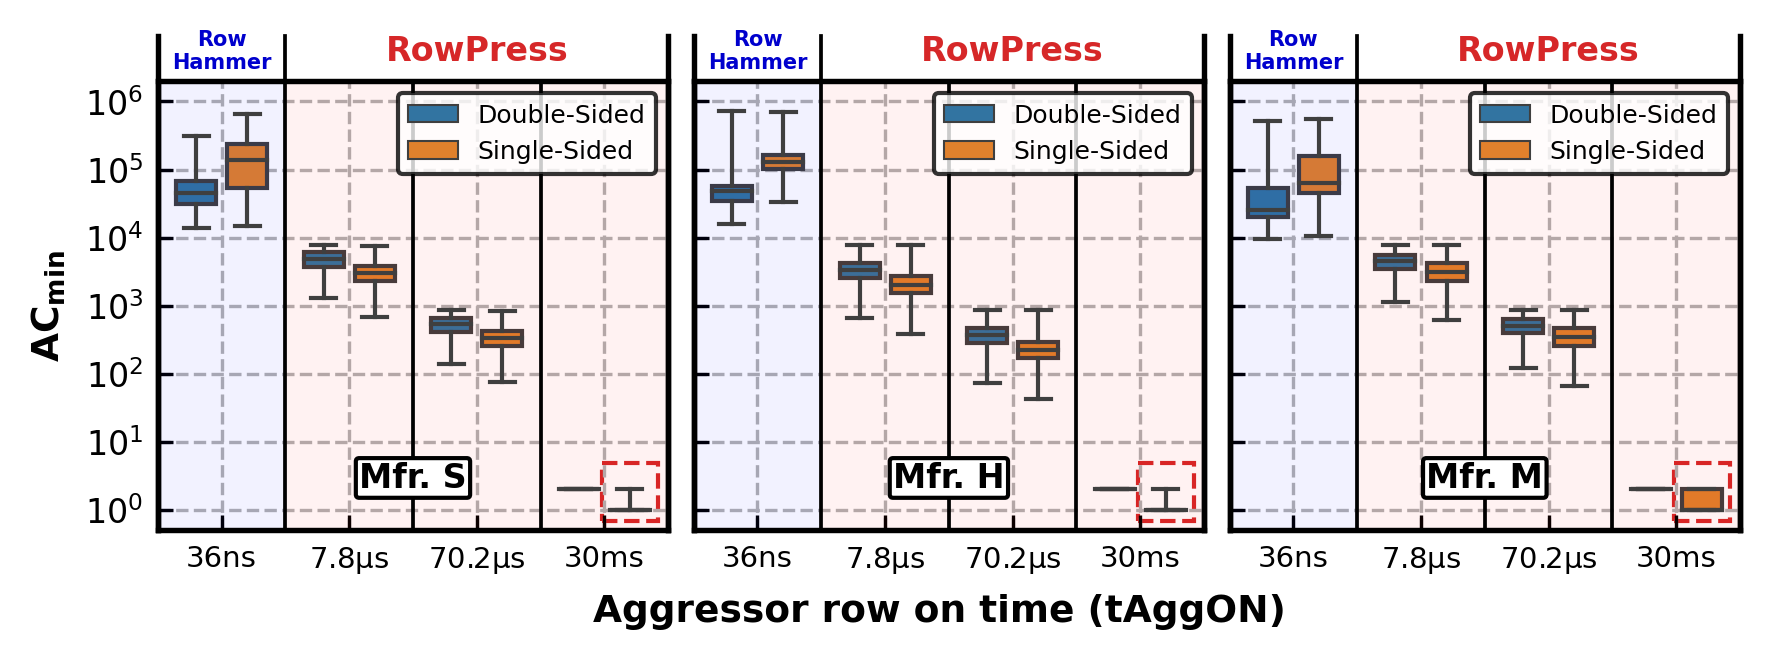

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2.4))

for i, mfr in enumerate(mfr_order):
  g = sns.boxplot(data=data.loc[data["mfr"] == mfr], x="x", y="ac_min", hue="p", hue_order = ["Double-Sided", "Single-Sided"], dodge=True, ax=axs[i], linewidth=1.0, whis=[0, 100])
  g.legend_.remove()
  # axs[i].legend(loc="upper right", ncol=1, edgecolor="black", fontsize=6, title=None)
  axs[i].legend(loc="upper right", ncol=1, edgecolor="black", fontsize=6, title=None)
  axs[i].text(0.5, 0.08, mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va="bottom", ha="center", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

for i, ax in enumerate(axs):
  ax.set_yscale("log")
  
  ax.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
  ax.set_ylim([0.5, 2000000])
  ax.tick_params(axis="y", direction="in", labelsize=8)

  if i > 0:
    ax.set_yticklabels([])

  ax.set_xticklabels(["36ns", r"7.8$\mu$s" , r"70.2$\mu$s", "30ms"], fontsize=7)
  ax.tick_params(axis="x",direction="in")

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  # ax.axhline(y=2, linewidth=0.9, color='red', linestyle="dashed")
  ax.axvline(x=0.5, linewidth=0.9, color='black', ymax=1.1, clip_on=False)
  ax.axvline(x=1.5, linewidth=0.9, color='black')
  ax.axvline(x=2.5, linewidth=0.9, color='black')

  ax.axvline(x=-0.5, linewidth=1.3, color='black', ymax=1.1, clip_on=False)
  ax.axvline(x=3.5, linewidth=1.3, color='black', ymax=1.1, clip_on=False)

  ax.text(x=0.0, y=3 * 10E5, s="Row" + "\n" + "Hammer", ha="center", fontsize=5,  weight="bold", color="mediumblue")
  ax.axhspan(0, 10E7, 0, 0.25, facecolor='blue', alpha=0.05)

  ax.text(x=2.0, y=4 * 10E5, s="RowPress", ha="center", fontsize=8,  weight="bold", color="tab:red")
  ax.axhspan(0, 10E7, 0.25, 1.0, facecolor='red', alpha=0.05)

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  rect = Rectangle((0.87,0.02), 0.11, 0.13, edgecolor='tab:red', linestyle = 'dashed', facecolor="None",  transform = ax.transAxes, zorder=0)
  ax.add_patch(rect)

adjust_box_widths(fig, 0.8)

axs[0].set_ylabel(r"$AC_{min}$", fontsize=9, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", x=0.53, y=0.10, fontsize=9, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.03)

plt.savefig("./output/Figure1.pdf", bbox_inches='tight', pad_inches=0.02)
plt.savefig("./output/Figure1.png", bbox_inches='tight', pad_inches=0.02)

## AC_min reduction numbers

In [11]:
data = hcf_data.copy()
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()
data = data[data["temperature"] == 80]
for module in data["module"].unique():
  for pattern in data["pattern"].unique():
    mask = (data["module"] == module) & (data["pattern"] == pattern)
    mask2 = (data["module"] == module) & (data["pattern"] == "double-checkered")
    df = data.loc[mask2]
    ac_min_base = df.loc[df["tAggON"] == df["tAggON"].min(), "ac_min"].values[0]

    data.loc[mask, "ac_min_reduction"] = ac_min_base / data.loc[mask, "ac_min"]

g = data.groupby(["pattern", "temperature", "tAggON"]).agg({'ac_min_reduction': ['min', 'mean', 'max']}).reset_index()
display(g.loc[(g["tAggON"] == 7776) | (g["tAggON"] == 70176)])

pattern temperature tAggON ac_min_reduction              \
                                                     min        mean   
8   double-checkered          80   7776         3.676089   11.689164   
11  double-checkered          80  70176        31.385086  106.295366   
28  single-checkered          80   7776         5.592443   17.601828   
31  single-checkered          80  70176        50.602072  159.394468   

                
           max  
8    31.778269  
11  295.994230  
28   40.668529  
31  363.788250

In [12]:
data = hcf_data.copy()
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()
data = data[data["temperature"] == 80]
for module in data["module"].unique():
  for pattern in data["pattern"].unique():
    mask = (data["module"] == module) & (data["pattern"] == pattern)
    mask2 = (data["module"] == module) & (data["pattern"] == "double-checkered")
    df = data.loc[mask2]
    ac_min_base = df.loc[df["tAggON"] == df["tAggON"].min(), "ac_min"].values[0]

    data.loc[mask, "ac_min_reduction"] = ac_min_base / data.loc[mask, "ac_min"]

g = data.groupby(["mfr", "die", "pattern", "temperature", "tAggON"]).agg({'ac_min_reduction': ['min', 'mean', 'max']}).reset_index()
display(g.loc[(g["tAggON"] == 7776) | (g["tAggON"] == 70176)])

mfr         die           pattern temperature tAggON ac_min_reduction  \
                                                                          min   
8    Mfr. H  16Gb A-Die  double-checkered          80   7776        14.925758   
11   Mfr. H  16Gb A-Die  double-checkered          80  70176       139.912029   
28   Mfr. H  16Gb A-Die  single-checkered          80   7776        25.567209   
31   Mfr. H  16Gb A-Die  single-checkered          80  70176       229.451892   
48   Mfr. H  16Gb C-Die  double-checkered          80   7776         7.435471   
51   Mfr. H  16Gb C-Die  double-checkered          80  70176        67.627499   
68   Mfr. H  16Gb C-Die  single-checkered          80   7776        11.842169   
71   Mfr. H  16Gb C-Die  single-checkered          80  70176       107.160983   
88   Mfr. H   4Gb A-Die  double-checkered          80   7776        31.778269   
91   Mfr. H   4Gb A-Die  double-checkered          80  70176       295.994230   
108  Mfr. H   4Gb A-Die  single-checkered          80   7776        35.330997   
111  Mfr. H   4Gb A-Die  single-checkered          80  70176       318.702027   
128  Mfr. H   4Gb X-Die  double-checkered          80   7776        17.873673   
131  Mfr. H   4Gb X-Die  double-checkered          80  70176       160.782142   
148  Mfr. H   4Gb X-Die  single-checkered          80   7776        28.430449   
151  Mfr. H   4Gb X-Die  single-checkered          80  70176       258.121673   
168  Mfr. M  16Gb B-Die  double-checkered          80   7776         6.984500   
171  Mfr. M  16Gb B-Die  double-checkered          80  70176        62.965395   
188  Mfr. M  16Gb B-Die  single-checkered          80   7776         7.443099   
191  Mfr. M  16Gb B-Die  single-checkered          80  70176        67.015236   
208  Mfr. M  16Gb E-Die  double-checkered          80   7776         3.676089   
211  Mfr. M  16Gb E-Die  double-checkered          80  70176        31.385086   
228  Mfr. M  16Gb E-Die  single-checkered          80   7776         5.592443   
231  Mfr. M  16Gb E-Die  single-checkered          80  70176        50.602072   
248  Mfr. M  16Gb F-Die  double-checkered          80   7776         6.678850   
251  Mfr. M  16Gb F-Die  double-checkered          80  70176        58.790325   
268  Mfr. M  16Gb F-Die  single-checkered          80   7776        10.763636   
271  Mfr. M  16Gb F-Die  single-checkered          80  70176        95.419026   
300  Mfr. S   4Gb F-Die  double-checkered          80   7776        13.189704   
303  Mfr. S   4Gb F-Die  double-checkered          80  70176       119.545683   
320  Mfr. S   4Gb F-Die  single-checkered          80   7776        21.338331   
323  Mfr. S   4Gb F-Die  single-checkered          80  70176       194.191391   
340  Mfr. S   8Gb B-Die  double-checkered          80   7776        19.229701   
343  Mfr. S   8Gb B-Die  double-checkered          80  70176       178.314943   
360  Mfr. S   8Gb B-Die  single-checkered          80   7776        28.965010   
363  Mfr. S   8Gb B-Die  single-checkered          80  70176       274.002826   
380  Mfr. S   8Gb C-Die  double-checkered          80   7776         7.247696   
383  Mfr. S   8Gb C-Die  double-checkered          80  70176        65.277391   
400  Mfr. S   8Gb C-Die  single-checkered          80   7776        11.118211   
403  Mfr. S   8Gb C-Die  single-checkered          80  70176       101.210671   
420  Mfr. S   8Gb D-Die  double-checkered          80   7776         5.281433   
423  Mfr. S   8Gb D-Die  double-checkered          80  70176        47.829422   
440  Mfr. S   8Gb D-Die  single-checkered          80   7776         8.397837   
443  Mfr. S   8Gb D-Die  single-checkered          80  70176        77.422744   

                             
           mean         max  
8     20.023676   25.121593  
11   182.310297  224.708565  
28    33.117869   40.668529  
31   296.620071  363.788250  
48     7.463898    7.492325  
51    68.138804   68.650109  
68    11.963430   12.084691  
71   108.43

# Section IV

## Figure 6
ACmin as tAggON increases; single-sided RowPress at 50C

/tmp/ipykernel_444740/524842381.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.lineplot(data=data, x="tAggON", y="ac_min", hue="die", linewidth=0.9, ax=axs[i], ci="sd", hue_order=hue_orders[mfr], marker=".", markeredgecolor='none', markersize=5)
/tmp/ipykernel_444740/524842381.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.lineplot(data=data, x="tAggON", y="ac_min", hue="die", linewidth=0.9, ax=axs[i], ci="sd", hue_order=hue_orders[mfr], marker=".", markeredgecolor='none', markersize=5)
/tmp/ipykernel_444740/524842381.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.lineplot(data=data, x="tAggON", y="ac_min", hue="die", linewidth=0.9, ax=axs[i], ci="sd", hue_order=hue_orders[mfr], marker=".", markeredgecolor='none', markersize=5)


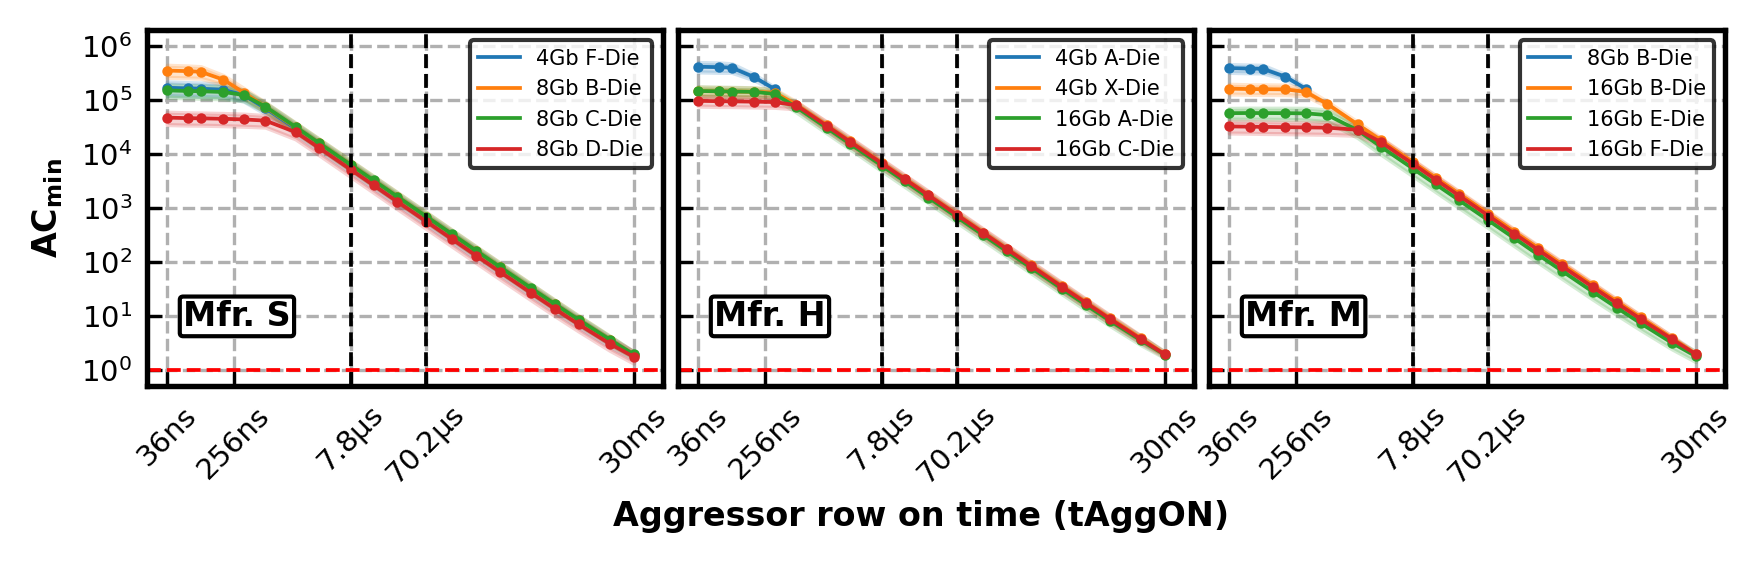

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2.1))
axs = axs.reshape(-1)

temp = 50
pattern = "single-checkered"

for i, mfr in enumerate(mfr_order):
  data = hcf_data.loc[(hcf_data["mfr"] == mfr) & (hcf_data["pattern"] == pattern) & (hcf_data["temperature"] == temp)]
  g = sns.lineplot(data=data, x="tAggON", y="ac_min", hue="die", linewidth=0.9, ax=axs[i], ci="sd", hue_order=hue_orders[mfr], marker=".", markeredgecolor='none', markersize=5)
  g.legend_.set_title(None)
  # axs[i].set_title(mfr, fontsize=10, weight="bold")
  axs[i].text(0.07, 0.15, mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
  
for i, ax in enumerate(axs):
  ax.loglog()
  ax.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
  ax.set_ylim([0.5, 2000000])
  ax.tick_params(axis="y", direction="in", labelsize=7)

  ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
  ax.set_xlim([20, 70000000])
  ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"70.2$\mu$s", "30ms"], rotation=45, ha='center', fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=7)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axhline(y=1, linewidth=0.9, color='red', linestyle="dashed")

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  if i != 0:
    ax.set_yticklabels([])

  l = ax.legend(loc='upper right', ncol=1, fontsize=5, columnspacing=0.7, edgecolor="black")
  for line in l.get_lines():
    line.set_linewidth(0.9)

axs[0].set_ylabel(r"$AC_{min}$", fontsize=8, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.13, x=0.52, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("./output/Figure6.pdf", bbox_inches='tight', pad_inches=0.01)
plt.savefig("./output/Figure6.png", bbox_inches='tight', pad_inches=0.01)

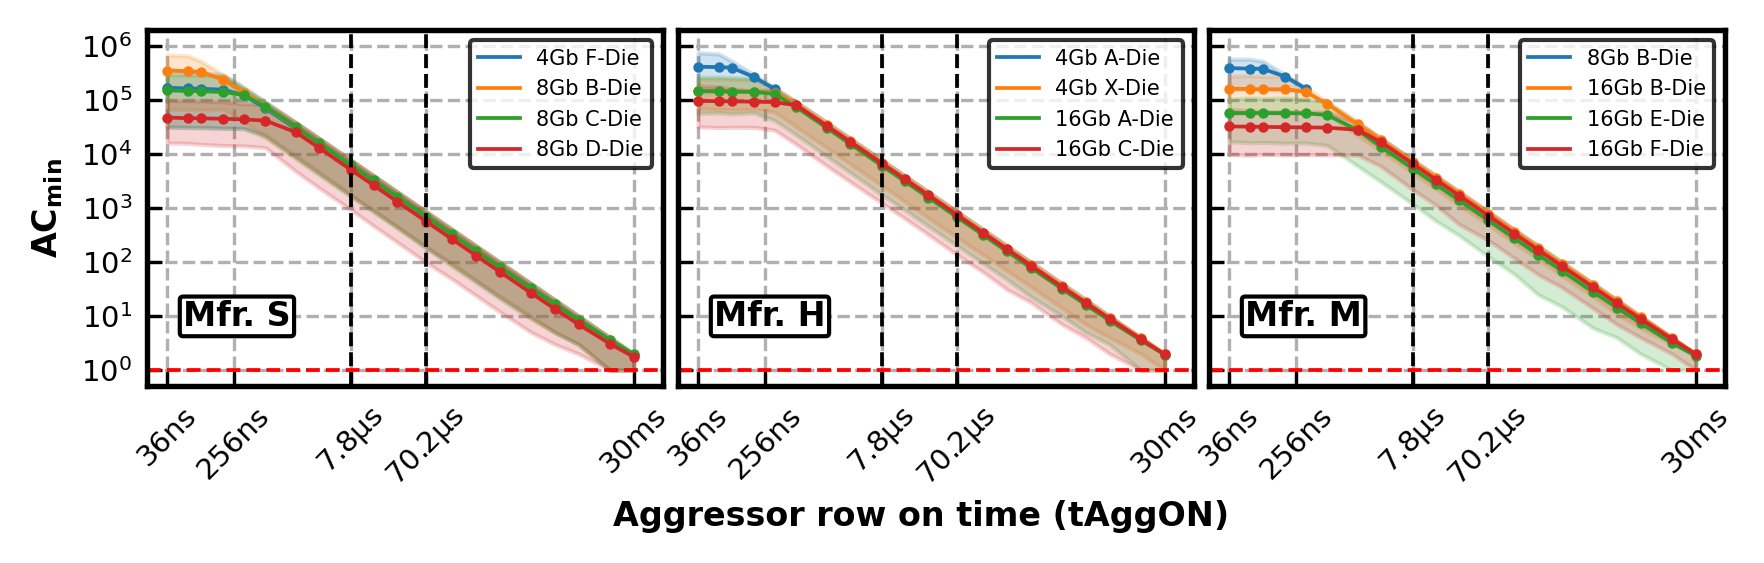

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2.1))
axs = axs.reshape(-1)

temp = 50
pattern = "single-checkered"

for i, mfr in enumerate(mfr_order):
  data = hcf_data.loc[(hcf_data["mfr"] == mfr) & (hcf_data["pattern"] == pattern) & (hcf_data["temperature"] == temp)]
  g = sns.lineplot(data=data, x="tAggON", y="ac_min", hue="die", linewidth=0.9, ax=axs[i], errorbar=("pi", 100), hue_order=hue_orders[mfr], marker=".", markeredgecolor='none', markersize=5)
  g.legend_.set_title(None)
  # axs[i].set_title(mfr, fontsize=10, weight="bold")
  axs[i].text(0.07, 0.15, mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
  
for i, ax in enumerate(axs):
  ax.loglog()
  ax.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
  ax.set_ylim([0.5, 2000000])
  ax.tick_params(axis="y", direction="in", labelsize=7)

  ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
  ax.set_xlim([20, 70000000])
  ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"70.2$\mu$s", "30ms"], rotation=45, ha='center', fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=7)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axhline(y=1, linewidth=0.9, color='red', linestyle="dashed")

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  if i != 0:
    ax.set_yticklabels([])

  l = ax.legend(loc='upper right', ncol=1, fontsize=5, columnspacing=0.7, edgecolor="black")
  for line in l.get_lines():
    line.set_linewidth(0.9)

axs[0].set_ylabel(r"$AC_{min}$", fontsize=8, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.13, x=0.52, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("./output/Figure6_band.pdf", bbox_inches='tight', pad_inches=0.01)
plt.savefig("./output/Figure6_band.png", bbox_inches='tight', pad_inches=0.01)

In [ ]:
mfr = "Mfr. S"
die = "8Gb D-Die"
temp = 50
pattern = "single-checkered"
data = hcf_data.loc[(hcf_data["mfr"] == mfr) & (hcf_data["pattern"] == pattern) & (hcf_data["temperature"] == temp) & (hcf_data["die"] == die)]
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()
display(data)


## Numbers mentioned when describing Figure 6

In [13]:
data = hcf_data.copy()
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()

for module in data["module"].unique():
  for pattern in data["pattern"].unique():
    for temperature in data["temperature"].unique():
      mask = (data["module"] == module) & (data["pattern"] == pattern) & (data["temperature"] == temperature)
      df = data.loc[mask]

      ac_min_base = df.loc[df["tAggON"] == df["tAggON"].min(), "ac_min"].values[0]
      data.loc[mask, "ac_min_reduction"] = ac_min_base / data.loc[mask, "ac_min"]

g = data.groupby(["pattern", "temperature", "tAggON"]).agg({'ac_min_reduction': ['min', 'mean', 'max']}).reset_index()
display(g.loc[((g["tAggON"] == 7776) | (g["tAggON"] == 70176)) & (g["pattern"] == "single-checkered") & (g["temperature"] == 50)])

g = data.groupby(["mfr", "die", "pattern", "temperature", "tAggON"]).agg({'ac_min_reduction': ['min', 'mean', 'max']}).reset_index()
display(g.loc[(g["tAggON"] == 7776) & (g["pattern"] == "single-checkered") & (g["temperature"] == 50)])
display(g.loc[(g["tAggON"] == 70176) & (g["pattern"] == "single-checkered") & (g["temperature"] == 50)])

pattern temperature tAggON ac_min_reduction              \
                                                     min        mean   
48  single-checkered          50   7776         4.965578   21.063422   
51  single-checkered          50  70176        45.007145  190.281297   

                
           max  
48   59.387598  
51  536.849270

mfr         die           pattern temperature tAggON ac_min_reduction  \
                                                                          min   
48   Mfr. H  16Gb A-Die  single-checkered          50   7776        21.085839   
128  Mfr. H  16Gb C-Die  single-checkered          50   7776        14.375826   
260  Mfr. H   4Gb X-Die  single-checkered          50   7776        21.620139   
340  Mfr. M  16Gb B-Die  single-checkered          50   7776        21.656926   
420  Mfr. M  16Gb E-Die  single-checkered          50   7776         7.822822   
500  Mfr. M  16Gb F-Die  single-checkered          50   7776         4.965578   
603  Mfr. S   4Gb F-Die  single-checkered          50   7776        25.467262   
683  Mfr. S   8Gb B-Die  single-checkered          50   7776        54.307064   
763  Mfr. S   8Gb C-Die  single-checkered          50   7776        24.166031   
843  Mfr. S   8Gb D-Die  single-checkered          50   7776         8.693265   

                           
          mean        max  
48   23.346682  25.607525  
128  14.527715  14.679603  
260  21.620139  21.620139  
340  22.112375  22.567824  
420   9.892123  13.101025  
500   4.965578   4.965578  
603  29.109613  32.751964  
683  56.847331  59.387598  
763  24.166031  24.166031  
843   9.296487   9.939799

mfr         die           pattern temperature tAggON ac_min_reduction  \
                                                                          min   
51   Mfr. H  16Gb A-Die  single-checkered          50  70176       190.575890   
131  Mfr. H  16Gb C-Die  single-checkered          50  70176       129.533130   
263  Mfr. H   4Gb X-Die  single-checkered          50  70176       195.254943   
343  Mfr. M  16Gb B-Die  single-checkered          50  70176       195.089439   
423  Mfr. M  16Gb E-Die  single-checkered          50  70176        70.567811   
503  Mfr. M  16Gb F-Die  single-checkered          50  70176        45.007145   
606  Mfr. S   4Gb F-Die  single-checkered          50  70176       231.028489   
686  Mfr. S   8Gb B-Die  single-checkered          50  70176       488.855800   
766  Mfr. S   8Gb C-Die  single-checkered          50  70176       217.100767   
846  Mfr. S   8Gb D-Die  single-checkered          50  70176        78.368876   

                             
           mean         max  
51   210.469722  230.363554  
131  131.077736  132.622342  
263  195.254943  195.254943  
343  199.145427  203.201414  
423   89.229099  118.601252  
503   45.007145   45.007145  
606  265.171062  299.313634  
686  512.852535  536.849270  
766  217.100767  217.100767  
846   84.287179   90.182134

In [14]:
data = hcf_data.copy()
data = data[(data["pattern"] == "single-checkered") & (data["temperature"] == 50)]
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON", "row"]).min().reset_index()

c = hcf_data.copy()

g = data[(data["tAggON"] == 30000036) & (data["ac_min"] == 1)]
g2 =  data[(data["tAggON"] == 30000036)]

print("Fraction of rows with ac_min = 1:")
print ((g.count()/g2.count())[0])

Fraction of rows with ac_min = 1:
0.13106528987149194


## Slope

In [15]:
from scipy import stats

data = hcf_data.copy()
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()
mask = (data["tAggON"] >= 7776) & (data["pattern"] == "single-checkered") & (data["temperature"] == 50)
data = data.loc[mask]

In [16]:
for mfr in data["mfr"].unique():
  g = data.loc[data["mfr"] == mfr]
  slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(g["tAggON"]), np.log(g["ac_min"]))
  print(mfr)
  print("slope: %f    intercept: %f" % (1/slope, intercept))
  print("r-squared: %f" % r_value**2)
  print()

Mfr. H
slope: -1.012994    intercept: 17.607835
r-squared: 0.999490

Mfr. M
slope: -1.012942    intercept: 17.594300
r-squared: 0.996249

Mfr. S
slope: -1.020330    intercept: 17.383798
r-squared: 0.998434



## Figure 7
The fraction of rows that experience at least one bitflip; single-sided RowPress at 50C

In [17]:
data = hcf_data.copy()
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).count().reset_index()
data.loc[:, "coverage"] = data["row"] / (3*1024)

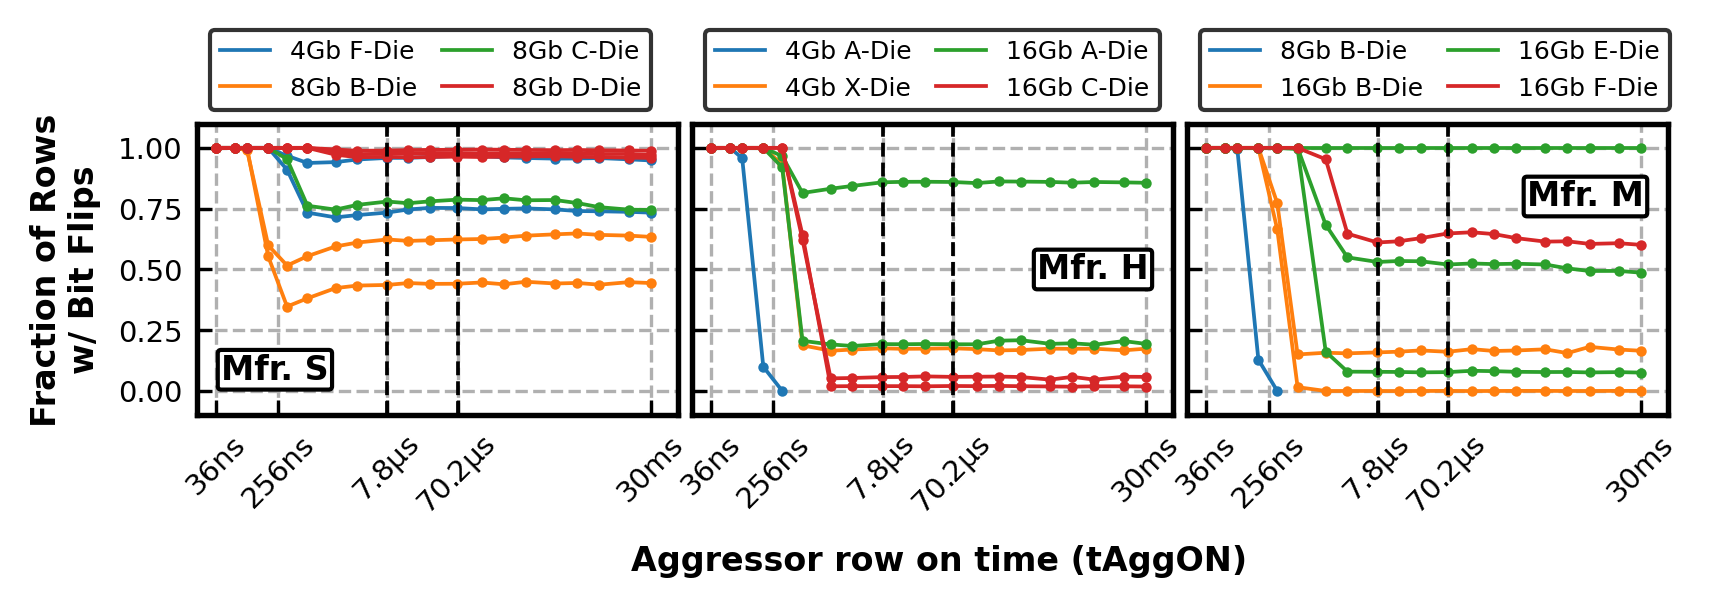

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2.2))
axs = axs.reshape(-1)

temp = 50
pattern = "single-checkered"

mfrlocs = {
  'Mfr. S': [0.05, 0.10, 'left', 'bottom'], 
  'Mfr. M': [0.95, 0.75, 'right', 'center'], 
  'Mfr. H': [0.95, 0.50, 'right', 'center']
}

for i, mfr in enumerate(mfr_order):
  g = sns.lineplot(data=data.loc[(data["mfr"] == mfr) & (data["pattern"] == pattern) & (data["temperature"] == temp)], x="tAggON", y="coverage", hue="die", units="module", estimator=None, hue_order=hue_orders[mfr], linewidth=0.9, ax=axs[i], marker=".", markersize=5, markeredgecolor="none")
  g.legend_.set_title(None)
  # axs[i].set_title(mfr, fontsize=10, weight="bold", pad=25.0)
  axs[i].text(mfrlocs[mfr][0], mfrlocs[mfr][1], mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va=mfrlocs[mfr][3], ha=mfrlocs[mfr][2], backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

for i, ax in enumerate(axs):
  ax.set_ylim([-0.1, 1.1])
  ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
  ax.tick_params(axis="y", direction="in", labelsize=7)

  ax.set_xscale("log")
  ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
  ax.set_xlim([20, 70000000])
  ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"70.2$\mu$s", "30ms"], rotation=45, ha='center', fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=7)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axhline(y=2, linewidth=0.9, color='red', linestyle="dashed")

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)


  if i != 0:
    ax.set_yticklabels([])

  l = ax.legend(bbox_to_anchor=(0, 1.003, 1, 0.2), loc="lower left", ncol=2, fontsize=6, columnspacing=1, edgecolor="black")
  for line in l.get_lines():
    line.set_linewidth(0.9)

axs[0].set_ylabel(r"Fraction of Rows" + "\n" + "w/ Bit Flips", fontsize=8, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.1, x=0.53, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("./output/Figure7.pdf", bbox_inches='tight', pad_inches=0)
plt.savefig("./output/Figure7.png", bbox_inches='tight', pad_inches=0)

## Figure 8
Overlap ratio of RowPress-vulnerable cells with RowHammer (first row) and retention failures (second row).

In [19]:
import warnings
warnings.filterwarnings("ignore")
def read_relation_data(temp, test, type):
    folder = "../processed_data/relation/"
    relation_df = pd.DataFrame(columns=['rp_bfs', 'tAggON', 'rh_overlap', 'ret_overlap', 'module', 'mfr', 'die', 'type', 'temp', 'test'])
    for data_file in os.listdir(folder):
        filename = folder + data_file
        module = data_file.split("_")[0]
        df = pd.read_csv(filename)
        df['rh_overlap'] = df['rp_rh_bfs'] / df['rp_bfs']
        df['ret_overlap'] = df['rp_ret_bfs'] / df['rp_bfs']
        df = df.drop(['rp_rh_bfs', 'rp_ret_bfs'], axis=1)
        df['module'] = module
        df['type'] = type
        df['test'] = test
        df['temp'] = temp
        df['mfr'] = module_to_annon_mfr(module)
        df['die'] = module_to_die(module)
        relation_df = relation_df.append(df,ignore_index=True)
    return relation_df

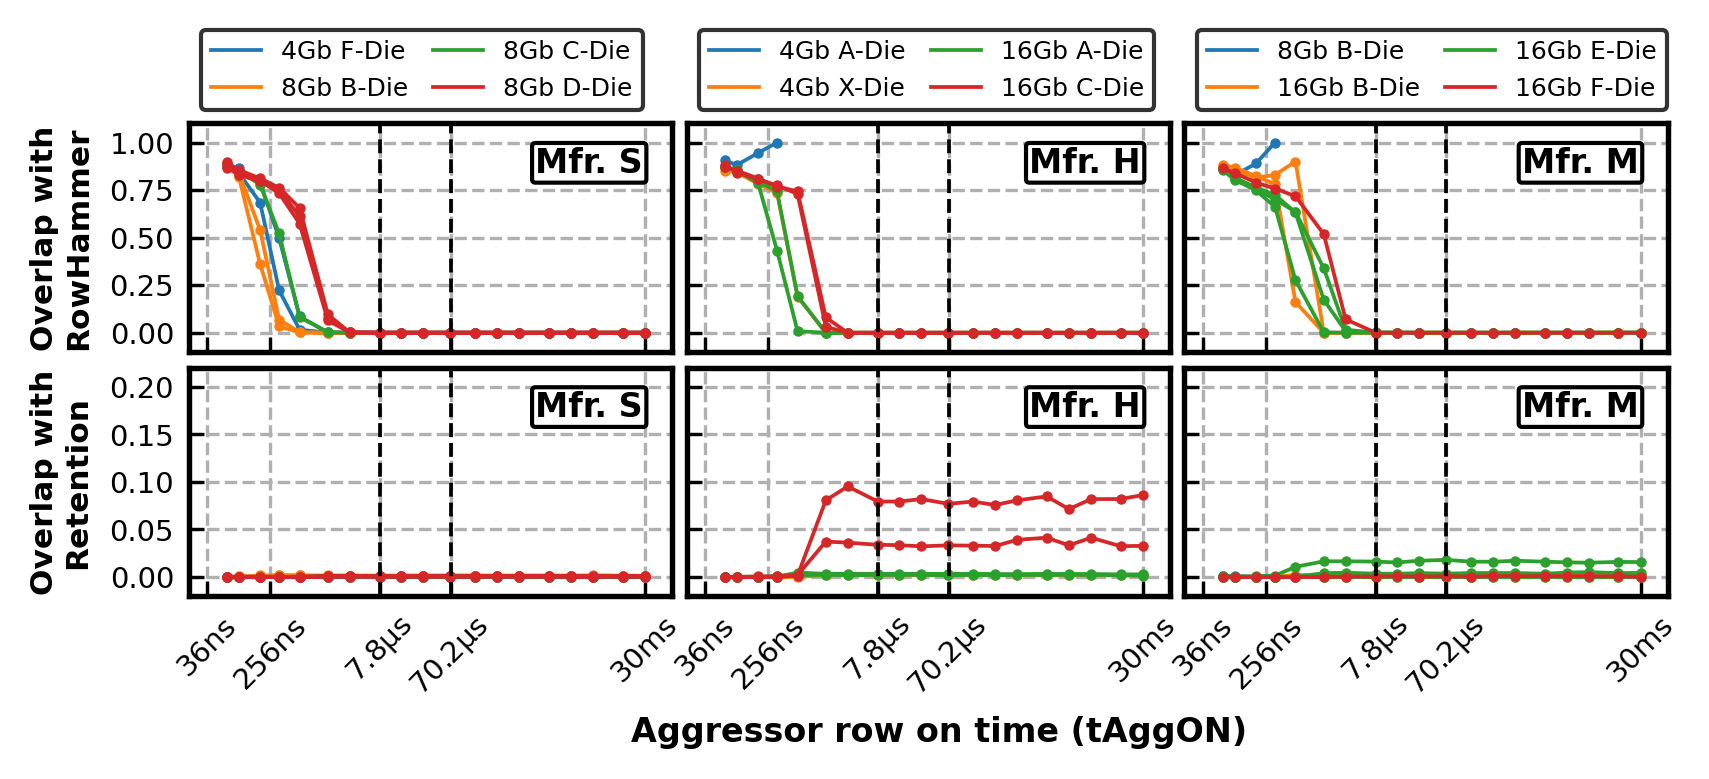

In [20]:
output_folder = "./output/"
temp = "50C"
test = "HCFIRST"
type = "single"

if not os.path.exists(output_folder):
   os.makedirs(output_folder)

relation_df = read_relation_data(temp, test, type)

fig, axs = plt.subplots(2, 3, figsize=(6, 2.8))
axs = axs.reshape(-1)

mfrs = relation_df["mfr"].unique()

for i, mfr in enumerate(mfr_order):
    data = relation_df.loc[(relation_df["mfr"] == mfr) & (relation_df["temp"] == temp) & (relation_df["type"] == type) & (relation_df["test"] == test)].copy()
    g = sns.lineplot(data=data, x="tAggON", y="rh_overlap", units='module', hue="die", estimator=None, ci="sd", linewidth=0.9, ax=axs[i], hue_order=hue_orders[mfr], marker=".", markersize=5, markeredgecolor="none")
    g = sns.lineplot(data=data, x="tAggON", y="ret_overlap", units='module', hue="die", estimator=None, ci="sd", linewidth=0.9, ax=axs[i + 3], hue_order=hue_orders[mfr],marker=".", markersize=5, markeredgecolor="none")
    g.legend_.set_title(None)

    if i < 3:
        axs[i].text(0.94, 0.9, mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va="top", ha="right", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
        axs[i+3].text(0.94, 0.9, mfr, transform=axs[i+3].transAxes, fontsize=8, weight="bold", va="top", ha="right", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
for i, ax in enumerate(axs):
    ax.set_xscale("log")
    ax.tick_params(axis="y", direction="in", labelsize=7)

    ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
    ax.set_xlim([20, 70000000])
    ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"70.2$\mu$s", "30ms"], rotation=45, ha='center', fontsize=7)
    ax.tick_params(axis="x",direction="in", labelsize=7)

    ax.minorticks_off()
    ax.set(xlabel=None, ylabel=None)
    ax.grid(linestyle='--')
    ax.set_axisbelow(True)

    ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
    ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)

    if i != 0 and i != 3:
        ax.set_yticklabels([])
    if i < 3:
        ax.set_xticklabels([])

    if i < 3:
        l = ax.legend(ncol=2, fontsize=6, columnspacing=1, bbox_to_anchor=(0, 1.003, 1, 0.2), loc="lower left", edgecolor="black")
        for line in l.get_lines():
            line.set_linewidth(0.9)
        ax.set_ylim([-0.1, 1.1])
        ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
    else:
        ax.legend().remove()
        ax.set_ylim([-0.02, 0.22])
        ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])

axs[0].set_ylabel(r"Overlap with" + "\n" + "RowHammer", fontsize=7.5, weight="bold")
axs[3].set_ylabel(r"Overlap with" + "\n" + "Retention", fontsize=7.5, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.09, x=0.53, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
title = "Figure8"
plt.savefig(output_folder + title + ".png", bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_folder + title + ".pdf", bbox_inches='tight', pad_inches=0.01)


In [ ]:
output_folder = "./output/"
temp = "50C"
test = "HCFIRST"
type = "single"

if not os.path.exists(output_folder):
   os.makedirs(output_folder)

relation_df = read_relation_data(temp, test, type)

fig, axs = plt.subplots(2, 3, figsize=(6, 2.8))
axs = axs.reshape(-1)

mfrs = relation_df["mfr"].unique()

for i, mfr in enumerate(mfr_order):
    data = relation_df.loc[(relation_df["mfr"] == mfr) & (relation_df["temp"] == temp) & (relation_df["type"] == type) & (relation_df["test"] == test)].copy()
    g = sns.lineplot(data=data, x="tAggON", y="rh_overlap", units='module', hue="die", estimator=None, ci="sd", linewidth=0.9, ax=axs[i], hue_order=hue_orders[mfr], marker=".", markersize=5, markeredgecolor="none")
    g = sns.lineplot(data=data, x="tAggON", y="ret_overlap", units='module', hue="die", estimator=None, ci="sd", linewidth=0.9, ax=axs[i + 3], hue_order=hue_orders[mfr],marker=".", markersize=5, markeredgecolor="none")
    g.legend_.set_title(None)

    if i < 3:
        axs[i].text(0.94, 0.9, mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va="top", ha="right", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
        axs[i+3].text(0.94, 0.9, mfr, transform=axs[i+3].transAxes, fontsize=8, weight="bold", va="top", ha="right", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
for i, ax in enumerate(axs):
    ax.set_xscale("log")
    ax.tick_params(axis="y", direction="in", labelsize=7)

    ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
    ax.set_xlim([20, 70000000])
    ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"70.2$\mu$s", "30ms"], rotation=45, ha='center', fontsize=7)
    ax.tick_params(axis="x",direction="in", labelsize=7)

    ax.minorticks_off()
    ax.set(xlabel=None, ylabel=None)
    ax.grid(linestyle='--')
    ax.set_axisbelow(True)

    ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
    ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)

    if i != 0 and i != 3:
        ax.set_yticklabels([])
    if i < 3:
        ax.set_xticklabels([])

    if i < 3:
        l = ax.legend(ncol=2, fontsize=6, columnspacing=1, bbox_to_anchor=(0, 1.003, 1, 0.2), loc="lower left", edgecolor="black")
        for line in l.get_lines():
            line.set_linewidth(0.9)
        ax.set_ylim([-0.1, 1.1])
        ax.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
    else:
        ax.legend().remove()
        ax.set_ylim([-0.02, 0.22])
        ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])

axs[0].set_ylabel(r"Overlap with" + "\n" + "RowHammer", fontsize=7.5, weight="bold")
axs[3].set_ylabel(r"Overlap with" + "\n" + "Retention", fontsize=7.5, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.09, x=0.53, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
title = "Figure8"
plt.savefig(output_folder + title + ".png", bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_folder + title + ".pdf", bbox_inches='tight', pad_inches=0.01)


## Average overlap numbers

In [21]:
temp = '50C'
type = 'single'
test = 'HCFIRST'
relation_df = read_relation_data(temp, test, type)

rel_df = relation_df.loc[(relation_df["temp"] == temp) & (relation_df["type"] == type) & (relation_df["test"] == test)].copy()
rel_df = rel_df.fillna(0)

rel_df = rel_df.drop(rel_df[rel_df['tAggON'] < 7776].index)
rel_df['dummy'] = 1
w_average_overlap = rel_df.groupby('dummy')['rh_overlap', 'ret_overlap'].agg(lambda x: np.average(x, weights=rel_df.loc[x.index, "rp_bfs"]))*100

print("Average overlap with RowHammer: " + str(w_average_overlap['rh_overlap'].values[0]) + "%")
print("Average overlap with Retention: " + str(w_average_overlap['ret_overlap'].values[0]) + "%")

Average overlap with RowHammer: 0.012906992214105158%
Average overlap with Retention: 0.33796462689856893%


## Figure 9
Fraction of “0” to “1” (first row) and “1” to “0” (second row) bitflips.

In [22]:
# os.chdir("F:\\ISCA-AE\\characterization\\analyze\\plots")
# print(os.getcwd())

def add_row_to_df_plot(tAggON: int, bitflip_direction: str, pattern: str, temperature: int, mfr: str, module: str, die: str, count: int, total_bitflips: int):
    add_row = [tAggON, bitflip_direction,  pattern, temperature, mfr, module, die, count, total_bitflips]
    return add_row


# from stackoverflow: https://stackoverflow.com/questions/9234560/find-all-csv-files-in-a-directory-using-python
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    p = os.path.normpath(os.path.join(os.getcwd(), path_to_dir))
    filenames = os.listdir(p)
    return [ os.path.join(p, filename) for filename in filenames if filename.endswith( suffix ) ]


# user input
selected_pattern = "single-checkered"
selected_experiment = "HCFIRST"
selected_temperature = 50

create_df = pd.DataFrame(columns=['tAggON','bitflip_direction', 'pattern', 'temperature', 'mfr', 'module', 'die', 'count', 'total_bitflips'])
current_dir = "../processed_data/hcf_bitflipdirection" 
# os.chdir(current_dir)
filenames_list = find_csv_filenames(current_dir)
for filename in filenames_list:
    # print(filename)
    df_tmp = pd.read_csv(filename)

    ndtAggONval = len(df_tmp) # number of different tAggON values
    df_tmp_1 = df_tmp['tAggON']
    my_list1 = []
    for i in range(ndtAggONval):
        my_list1.append(df_tmp_1.iloc[i])
    my_list2 = ['dir0', 'dir1']
    for count in my_list2:
        for i in my_list1:
            x = df_tmp.index[df_tmp['tAggON'] == i].tolist()
            if (len(x)!=0):
                count_in_loop = df_tmp.at[x[0], count]
                placeholder = ''
                if (count == 'dir0'):
                    placeholder = '0'
                elif (count == 'dir1'):
                    placeholder = '1'
                pattern = df_tmp.at[x[0],'pattern']
                temperature = df_tmp.at[x[0], 'temperature']
                total_bitflips = df_tmp.at[x[0], 'total_bitflips']
                mfr = module_to_annon_mfr(df_tmp.at[x[0], 'module'])
                module = df_tmp.at[x[0], 'module']
                die = module_to_die(df_tmp.at[x[0],'module'])
                add_row = add_row_to_df_plot(i, placeholder, pattern, temperature, mfr, module, die, count_in_loop, total_bitflips)
                create_df.loc[len(create_df)] = add_row
    
    create_df.reset_index()
    # zero values in multiple columns to np.nan: https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan
    columns = ['count']
    create_df[columns] = create_df[columns].replace({np.nan:0})
    create_df = create_df[create_df['total_bitflips']!=0]
    create_df.reset_index()

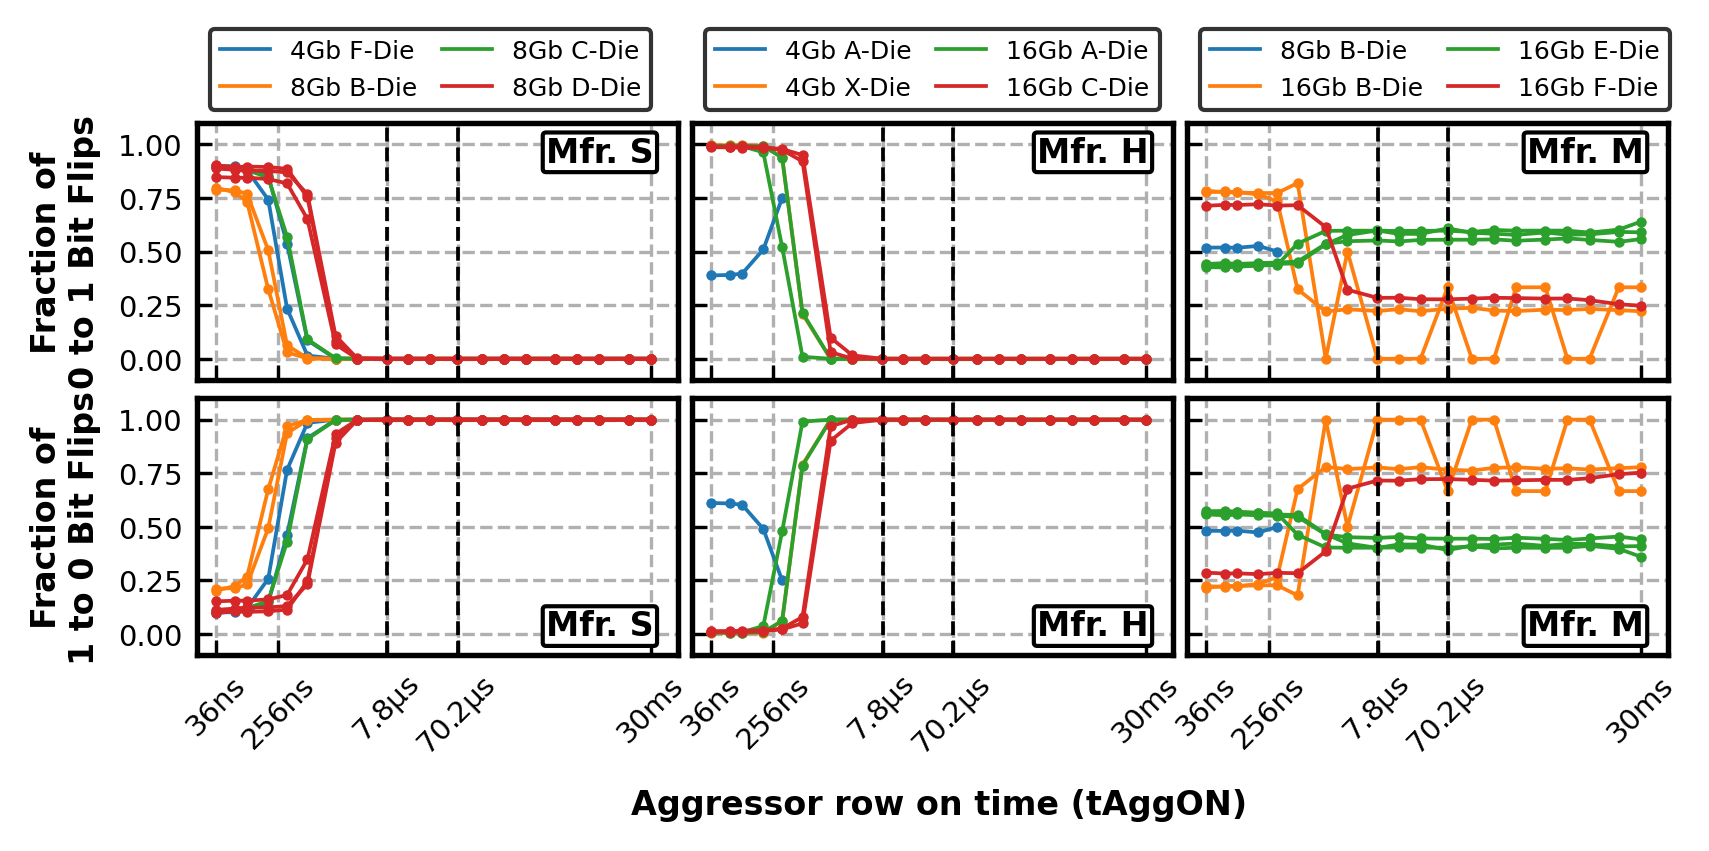

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(6, 3))
axs = axs.reshape(-1)

mfrs = create_df["mfr"].unique()
mfrs.sort()

# print(mfrs)

for i, mfr in enumerate(mfrs):
    j = 0
    if i == 0:
      j = 1
    elif i == 1:
      j = 2

    data = create_df.loc[(create_df["mfr"]==mfr) & (create_df["pattern"]==selected_pattern) & (create_df["temperature"]==selected_temperature)].copy()
    
    data.loc[:, "dir0_ratio"] = (data[data["bitflip_direction"] == '0'])['count'] / data["total_bitflips"]
    data.loc[:, "dir1_ratio"] = (data[data["bitflip_direction"] == '1'])['count']  / data["total_bitflips"]
    
    columns = ['dir0_ratio', 'dir1_ratio']

    
    if data["dir0_ratio"].isnull().all():
      # zero values in multiple columns to np.nan: https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan
      columns = ['dir0_ratio']
      data[columns] = data[columns].replace({np.nan:np.inf})

      
    g = sns.lineplot(data=data, x="tAggON", y="dir0_ratio", hue="die", units="module", estimator=None, ci="sd", linewidth=0.9, ax=axs[j], hue_order=hue_orders[mfr], marker=".", markersize=5, markeredgecolor="none")
    if data["dir1_ratio"].isnull().all():
      # zero values in multiple columns to np.nan: https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan
      columns = ['dir1_ratio']
      data[columns] = data[columns].replace({np.nan:np.inf})
    g = sns.lineplot(data=data, x="tAggON", y="dir1_ratio", hue="die", units="module", estimator=None, ci="sd", linewidth=0.9, ax=axs[j + 3], hue_order=hue_orders[mfr],marker=".", markersize=5, markeredgecolor="none")
    g.legend_.set_title(None)

    if j < 3:
        axs[j].text(0.95, 0.95, mfr, transform=axs[j].transAxes, fontsize=8, weight="bold", va="top", ha="right", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
        axs[j+3].text(0.95, 0.05, mfr, transform=axs[j+3].transAxes, fontsize=8, weight="bold", va="bottom", ha="right", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
    

for i, ax in enumerate(axs):
  ax.set_xscale("log")
  ax.set_ylim([-0.1, 1.1])
  ax.tick_params(axis="y", direction="in", labelsize=7)

  ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
  ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.0])
  ax.set_xlim([20, 70000000])
  ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"70.2$\mu$s", "30ms"], rotation=45, ha='center', fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=7)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axhline(y=2, linewidth=0.9, color='red', linestyle="dashed")

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  if i != 0 and i != 3:
    ax.set_yticklabels([])
  if i < 3:
    ax.set_xticklabels([])

  if i < 3:
    l = ax.legend(ncol=2, fontsize=6, columnspacing=1, bbox_to_anchor=(0, 1.003, 1, 0.2), loc="lower left", edgecolor="black")
    for line in l.get_lines():
      line.set_linewidth(0.9)
  else:
    ax.legend().remove()

axs[0].set_ylabel(r"Fraction of" + "\n" + "0 to 1 Bit Flips", fontsize=8, weight="bold")
axs[3].set_ylabel(r"Fraction of" + "\n" + "1 to 0 Bit Flips", fontsize=8, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.07, x=0.53, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("./output/Figure9.pdf", bbox_inches='tight', pad_inches=0.012)
plt.savefig("./output/Figure9.png", bbox_inches='tight', pad_inches=0.012)

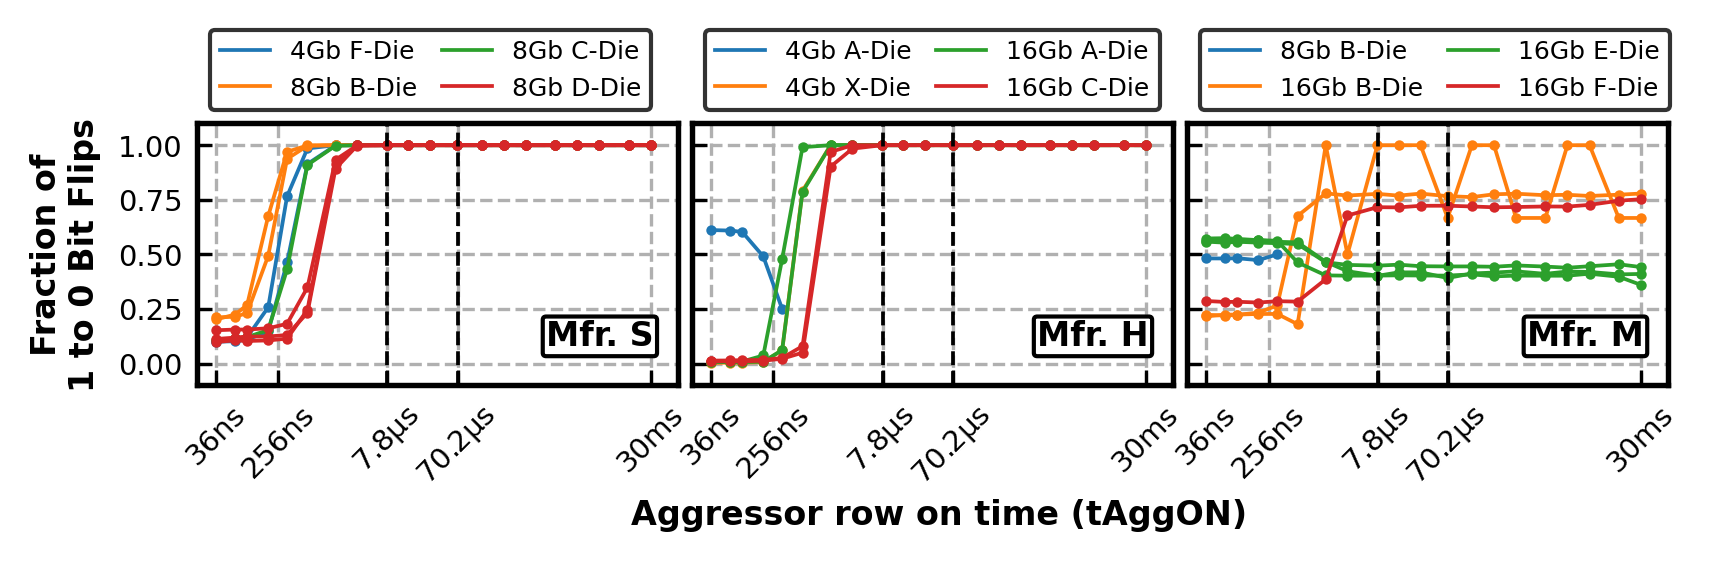

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2.1))
axs = axs.reshape(-1)

mfrs = create_df["mfr"].unique()
mfrs.sort()

# print(mfrs)

for i, mfr in enumerate(mfrs):
    j = 0
    if i == 0:
      j = 1
    elif i == 1:
      j = 2



    data = create_df.loc[(create_df["mfr"]==mfr) & (create_df["pattern"]==selected_pattern) & (create_df["temperature"]==selected_temperature)].copy()
    
    data.loc[:, "dir0_ratio"] = (data[data["bitflip_direction"] == '0'])['count'] / data["total_bitflips"]
    data.loc[:, "dir1_ratio"] = (data[data["bitflip_direction"] == '1'])['count']  / data["total_bitflips"]
    
    columns = ['dir0_ratio', 'dir1_ratio']

    
    if data["dir0_ratio"].isnull().all():
      # zero values in multiple columns to np.nan: https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan
      columns = ['dir0_ratio']
      data[columns] = data[columns].replace({np.nan:np.inf})

      
  
    if data["dir1_ratio"].isnull().all():
      # zero values in multiple columns to np.nan: https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan
      columns = ['dir1_ratio']
      data[columns] = data[columns].replace({np.nan:np.inf})
    # g = sns.lineplot(data=data, x="tAggON", y="dir1_ratio", hue="die", units="module", estimator=None, ci="sd", linewidth=0.9, ax=axs[j + 3], hue_order=hue_orders[mfr],marker=".", markersize=5, markeredgecolor="none")
    g = sns.lineplot(data=data, x="tAggON", y="dir1_ratio", hue="die", units="module", estimator=None, ci="sd", linewidth=0.9, ax=axs[j], hue_order=hue_orders[mfr], marker=".", markersize=5, markeredgecolor="none")
    g.legend_.set_title(None)

    if j < 3:
        axs[j].text(0.95, 0.25, mfr, transform=axs[j].transAxes, fontsize=8, weight="bold", va="top", ha="right", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
        # axs[j+3].text(0.95, 0.05, mfr, transform=axs[j+3].transAxes, fontsize=8, weight="bold", va="bottom", ha="right", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
    

for i, ax in enumerate(axs):
  if i >= 3:
    continue
  ax.set_xscale("log")
  ax.set_ylim([-0.1, 1.1])
  ax.tick_params(axis="y", direction="in", labelsize=7)

  ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
  ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.0])
  ax.set_xlim([20, 70000000])
  ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"70.2$\mu$s", "30ms"], rotation=45, ha='center', fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=7)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axhline(y=2, linewidth=0.9, color='red', linestyle="dashed")

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  if i != 0 and i != 3:
    ax.set_yticklabels([])


  if i < 3:
    l = ax.legend(ncol=2, fontsize=6, columnspacing=1, bbox_to_anchor=(0, 1.003, 1, 0.2), loc="lower left", edgecolor="black")
    for line in l.get_lines():
      line.set_linewidth(0.9)
  else:
    ax.legend().remove()

axs[0].set_ylabel(r"Fraction of" + "\n" + "1 to 0 Bit Flips", fontsize=8, weight="bold")
# axs[3].set_ylabel(r"Fraction of" + "\n" + "1 to 0 Bit Flips", fontsize=8, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.13, x=0.53, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("./output/Figure9_singlerow.pdf", bbox_inches='tight', pad_inches=0.012)
plt.savefig("./output/Figure9_singlerow.png", bbox_inches='tight', pad_inches=0.012)

# Section V

## Figure 10
ACmin at 80C normalized to 50C; Single-sided RowPress.

mfr  tAggON  temperature_50    ac_min_50  temperature_80    ac_min_80  \
0  Mfr. S    7776            50.0  5728.548184            80.0  3127.899251   
1  Mfr. S   70176            50.0   632.914380            80.0   342.750610   

      ratio  
0  0.549133  
1  0.544742

mfr  tAggON  temperature_50    ac_min_50  temperature_80    ac_min_80  \
0  Mfr. H    7776            50.0  6591.968180            80.0  2857.826823   
1  Mfr. H   70176            50.0   730.593891            80.0   316.483653   

      ratio  
0  0.321455  
1  0.321055

mfr  tAggON  temperature_50    ac_min_50  temperature_80    ac_min_80  \
0  Mfr. M    7776            50.0  6582.105433            80.0  4030.678360   
1  Mfr. M   70176            50.0   729.938047            80.0   447.419247   

      ratio  
0  0.593649  
1  0.593583

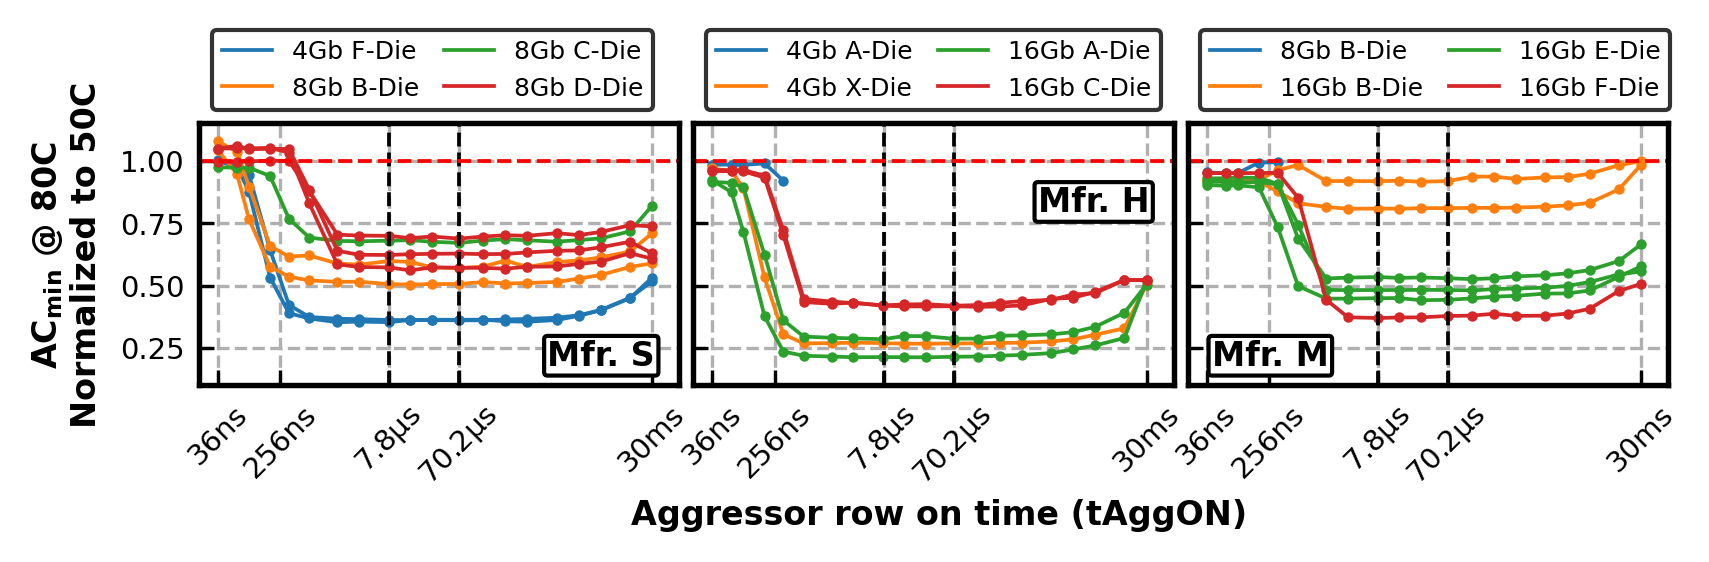

In [25]:
data = hcf_data.copy()
data = data.loc[data["pattern"] == "single-checkered"]
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()
data = data.drop(["row", "pattern", "hcf", "itr", "atk_time_ns"], axis=1)

data_50 = data.loc[data["temperature"] == 50]
data_80 = data.loc[data["temperature"] == 80]

data = pd.merge(left=data_50, right=data_80, how="right", on=["mfr", "die", "module", "tAggON"], suffixes=["_50", "_80"])
data["ratio"] = data["ac_min_80"] / data["ac_min_50"]

mfrlocs = {
  'Mfr. S': [0.95, 0.05, 'right', 'bottom'], 
  'Mfr. M': [0.05, 0.05, 'left', 'bottom'], 
  'Mfr. H': [0.95, 0.7, 'right', 'center']
}

fig, axs = plt.subplots(1, 3, figsize=(6, 2.1))
axs = axs.reshape(-1)
for i, mfr in enumerate(mfr_order):
  d = data.loc[(data["mfr"] == mfr)]
  g = sns.lineplot(data=d, x="tAggON", y="ratio", hue="die", units="module", linewidth=0.9, ax=axs[i],
  estimator=None, hue_order=hue_orders[mfr], marker=".", markeredgecolor='none', markersize=5)
  g.legend_.set_title(None)

  m = (d["tAggON"] == 7776) | (d["tAggON"] == 70176)

  display(d.loc[m].groupby(["mfr", "tAggON"]).mean().reset_index())

  # axs[i].set_title(mfr, fontsize=10, weight="bold", pad=25.0)
  axs[i].text(mfrlocs[mfr][0], mfrlocs[mfr][1], mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va=mfrlocs[mfr][3], ha=mfrlocs[mfr][2], backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

for i, ax in enumerate(axs):
  # ax.set_yticks([-0.5, 0, 0.5, 1, 1.])
  ax.set_ylim([0.1, 1.15])
  ax.set_yticks([0.25, 0.5, 0.75, 1.0])
  ax.tick_params(axis="y", direction="in", labelsize=7)

  ax.set_xscale("log")
  ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
  ax.set_xlim([20, 70000000])
  ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"$70.2\mu s$", "30ms"], rotation=45, ha='center', fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=7)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axhline(y=1.0, linewidth=0.9, color='red', linestyle="dashed")

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  if i != 0:
    ax.set_yticklabels([])

  l = ax.legend(bbox_to_anchor=(0, 1.003, 1, 0.2), loc="lower left", ncol=2, fontsize=6, columnspacing=1,  edgecolor="black")
  for line in l.get_lines():
    line.set_linewidth(0.9)

axs[0].set_ylabel(r"$AC_{min}$ @ 80C" + "\n" + r"Normalized to 50C", fontsize=8, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.13, x=0.53, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("./output/Figure10.pdf", bbox_inches='tight', pad_inches=0.03)
plt.savefig("./output/Figure10.png", bbox_inches='tight', pad_inches=0.03)

In [26]:
data = hcf_data.copy()
data = data[data["pattern"] == "single-checkered"]
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()

for module in data["module"].unique():
  for pattern in data["pattern"].unique():
    for temperature in data["temperature"].unique():
      mask = (data["module"] == module) & (data["pattern"] == pattern) & (data["temperature"] == temperature)
      df = data.loc[mask]

      ac_min_base = df.loc[df["tAggON"] == df["tAggON"].min(), "ac_min"].values[0]
      data.loc[mask, "ac_min_reduction"] = ac_min_base / data.loc[mask, "ac_min"]

g = data.groupby(["pattern", "temperature", "tAggON"]).agg({'ac_min_reduction': ['min', 'mean', 'max']}).reset_index()
display(g.loc[((g["tAggON"] == 7776) | (g["tAggON"] == 70176))])

pattern temperature tAggON ac_min_reduction              \
                                                     min        mean   
8   single-checkered          50   7776         4.965578   21.063422   
11  single-checkered          50  70176        45.007145  190.281297   
28  single-checkered          80   7776        12.768974   48.315239   
31  single-checkered          80  70176       113.196231  437.883909   

                 
            max  
8     59.387598  
11   536.849270  
28   122.586842  
31  1106.274896

In [27]:
data = hcf_data.copy()
data = data[data["pattern"] == "single-checkered"]
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()

for module in data["module"].unique():
  for pattern in data["pattern"].unique():
    for temperature in data["temperature"].unique():
      mask = (data["module"] == module) & (data["pattern"] == pattern) & (data["temperature"] == temperature)
      df = data.loc[mask]

      ac_min_base = df.loc[df["tAggON"] == df["tAggON"].min(), "ac_min"].values[0]
      data.loc[mask, "ac_min_reduction"] = ac_min_base / data.loc[mask, "ac_min"]

g = data.groupby(["mfr", "die", "pattern", "temperature", "tAggON"]).agg({'ac_min_reduction': ['min', 'mean', 'max']}).reset_index()
display(g.loc[(g["tAggON"] == 7776) & (g["pattern"] == "single-checkered") & (g["temperature"] == 80)])

mfr         die           pattern temperature tAggON ac_min_reduction  \
                                                                          min   
28   Mfr. H  16Gb A-Die  single-checkered          80   7776        67.753854   
68   Mfr. H  16Gb C-Die  single-checkered          80   7776        32.902536   
93   Mfr. H   4Gb A-Die  single-checkered          80   7776        63.139174   
133  Mfr. H   4Gb X-Die  single-checkered          80   7776        77.798273   
173  Mfr. M  16Gb B-Die  single-checkered          80   7776        21.772818   
213  Mfr. M  16Gb E-Die  single-checkered          80   7776        14.866538   
253  Mfr. M  16Gb F-Die  single-checkered          80   7776        12.768974   
303  Mfr. S   4Gb F-Die  single-checkered          80   7776        70.532834   
343  Mfr. S   8Gb B-Die  single-checkered          80   7776        97.804772   
383  Mfr. S   8Gb C-Die  single-checkered          80   7776        34.617615   
423  Mfr. S   8Gb D-Die  single-checkered          80   7776        14.167656   

                             
           mean         max  
28    89.217956  110.682058  
68    33.247680   33.592824  
93    63.139174   63.139174  
133   77.798273   77.798273  
173   23.771289   25.769760  
213   18.805694   26.317900  
253   12.768974   12.768974  
303   81.514430   92.496027  
343  110.195807  122.586842  
383   34.617615   34.617615  
423   15.223109   15.918738

In [28]:
data = hcf_data.copy()
data = data[(data["pattern"] == "single-checkered") & (data["temperature"] == 80)]
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON", "row"]).min().reset_index()

c = hcf_data.copy()

g = data[(data["tAggON"] == 30000036) & (data["ac_min"] == 1)]
g2 =  data[(data["tAggON"] == 30000036)]

print("Fraction of rows with ac_min = 1:")
print ((g.count()/g2.count())[0])

Fraction of rows with ac_min = 1:
0.8275843464498956


# Finer-Grained Temperature Sweep

In [ ]:
data = mintAggON_data.copy()
data = data[data["act_count"] == 1]

fig, axs = plt.subplots(1, 3, figsize=(6, 1.9))

mfrlocs = {
  'Mfr. S': [0.6, 0.1, 'center', 'center'], 
  'Mfr. M': [0.6, 0.1, 'center', 'center'], 
  'Mfr. H': [0.6, 0.1, 'center', 'center']
}


for i, mfr in enumerate(mfr_order):
  g = sns.lineplot(data=data.loc[data["mfr"] == mfr], x="temperature", y="min_tAggON_ms", hue="die", ci="sd", hue_order=hue_orders[mfr], ax=axs[i], marker=".", markeredgecolor='none', markersize=7)
  # axs[i].legend(loc="upper right", ncol=1, edgecolor="black", fontsize=6, title=None)
  # axs[i].legend(loc="lower left", ncol=1, edgecolor="black", fontsize=6, title=None)
  # axs[i].set_title(mfr, fontsize=10, weight="bold")
  axs[i].text(mfrlocs[mfr][0], mfrlocs[mfr][1], mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va=mfrlocs[mfr][3], ha=mfrlocs[mfr][2], backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

for i, ax in enumerate(axs):
  ax.set_yticks([10, 20, 30, 40, 50, 60])
  ax.set_ylim([8, 62])
  ax.yaxis.get_ticklocs(minor=True)
  ax.tick_params(axis="y", direction="in", labelsize=8)
  ax.tick_params(axis="y", which='minor', direction='in')

  ax.set_xticks([50, 60, 70, 80])
  ax.set_xlim([48, 82])
  ax.tick_params(axis="x", direction="in", labelsize=8)
  ax.tick_params(axis="x",  which='minor', direction="in")

  

  ax.minorticks_on()
  minor_locator = ticker.MultipleLocator(5)
  ax.xaxis.set_minor_locator(minor_locator)
  ax.yaxis.set_minor_locator(minor_locator)

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  l = ax.legend(loc="lower left", ncol=1, edgecolor="black", fontsize=5, title=None, columnspacing=0.7)
  for line in l.get_lines():
    line.set_linewidth(0.9)

  if i > 0:
    ax.set_yticklabels([])



axs[0].set_ylabel(r"$tAggON_{min} (ms)$", fontsize=8, weight="bold")
fig.supxlabel(r"Temperature ($^\circ C$)", y=0.13, x=0.53, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.03)
plt.savefig("./output/fine-grained-temperature-tAggONmin.pdf", bbox_inches='tight', pad_inches=0.01)
plt.savefig("./output/fine-grained-temperature-tAggONmin.png", bbox_inches='tight', pad_inches=0.01)

## Figure 11
The fraction of rows that experience at least one bitflip at 80C; Single-sided RowPress.

In [29]:
data = hcf_data.copy()
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).count().reset_index()
data.loc[:, "coverage"] = data["row"] / (3*1024)

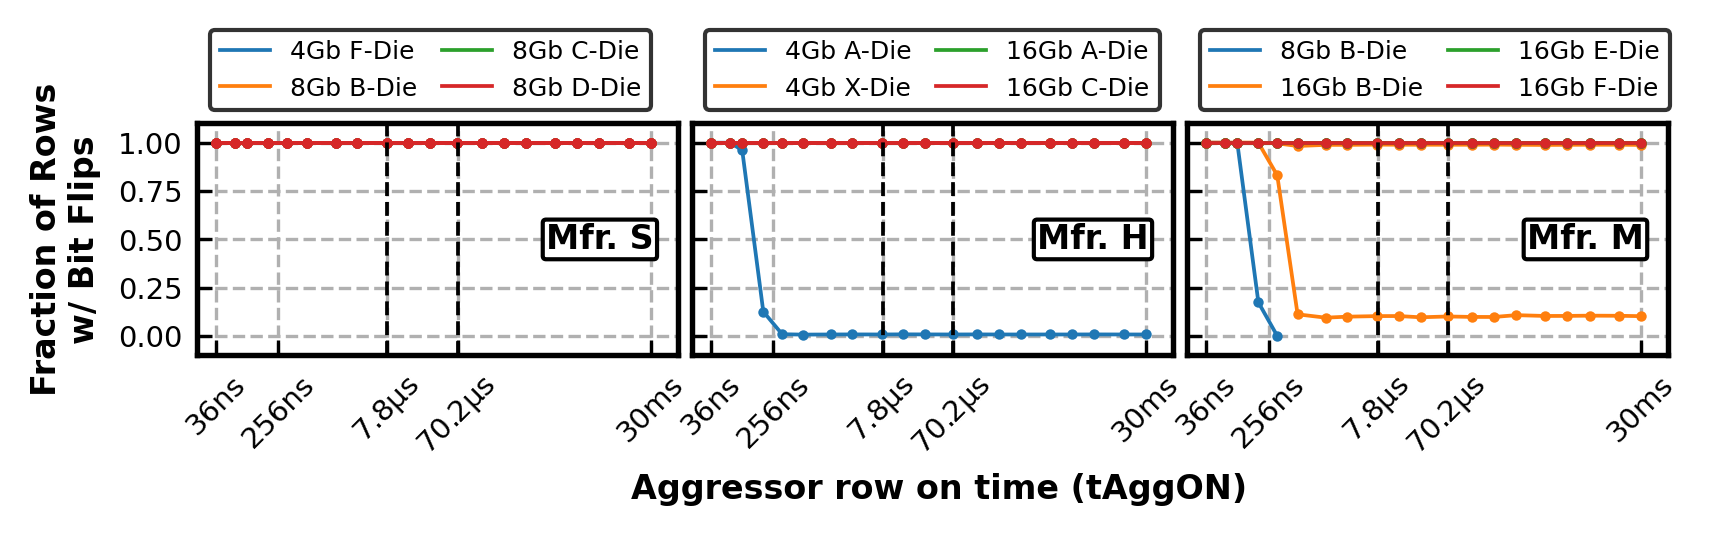

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2.0))
axs = axs.reshape(-1)

temp = 80
pattern = "single-checkered"

mfrlocs = {
  'Mfr. S': [0.95, 0.50, 'right', 'center'], 
  'Mfr. M': [0.95, 0.50, 'right', 'center'], 
  'Mfr. H': [0.95, 0.50, 'right', 'center']
}

for i, mfr in enumerate(mfr_order):
  g = sns.lineplot(data=data.loc[(data["mfr"] == mfr) & (data["pattern"] == pattern) & (data["temperature"] == temp)], x="tAggON", y="coverage", hue="die", units="module", estimator=None, hue_order=hue_orders[mfr], linewidth=0.9, ax=axs[i], marker=".", markersize=5, markeredgecolor="none")
  g.legend_.set_title(None)
  # axs[i].set_title(mfr, fontsize=10, weight="bold", pad=25.0)
  axs[i].text(mfrlocs[mfr][0], mfrlocs[mfr][1], mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va=mfrlocs[mfr][3], ha=mfrlocs[mfr][2], backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

for i, ax in enumerate(axs):
  ax.set_ylim([-0.1, 1.1])
  ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
  ax.tick_params(axis="y", direction="in", labelsize=7)

  ax.set_xscale("log")
  ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
  ax.set_xlim([20, 70000000])
  ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"70.2$\mu$s", "30ms"], rotation=45, ha='center', fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=7)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axhline(y=2, linewidth=0.9, color='red', linestyle="dashed")

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  if i != 0:
    ax.set_yticklabels([])

  l = ax.legend(bbox_to_anchor=(0, 1.003, 1, 0.2), loc="lower left", ncol=2, fontsize=6, columnspacing=1,  edgecolor="black")
  for line in l.get_lines():
    line.set_linewidth(0.9)

axs[0].set_ylabel(r"Fraction of Rows" + "\n" + "w/ Bit Flips", fontsize=8, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.13, x=0.53, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("./output/Figure11.pdf", bbox_inches='tight', pad_inches=0.03)
plt.savefig("./output/Figure11.png", bbox_inches='tight', pad_inches=0.03)

## Figure 13
ACmin of double-sided RowPress; 50C

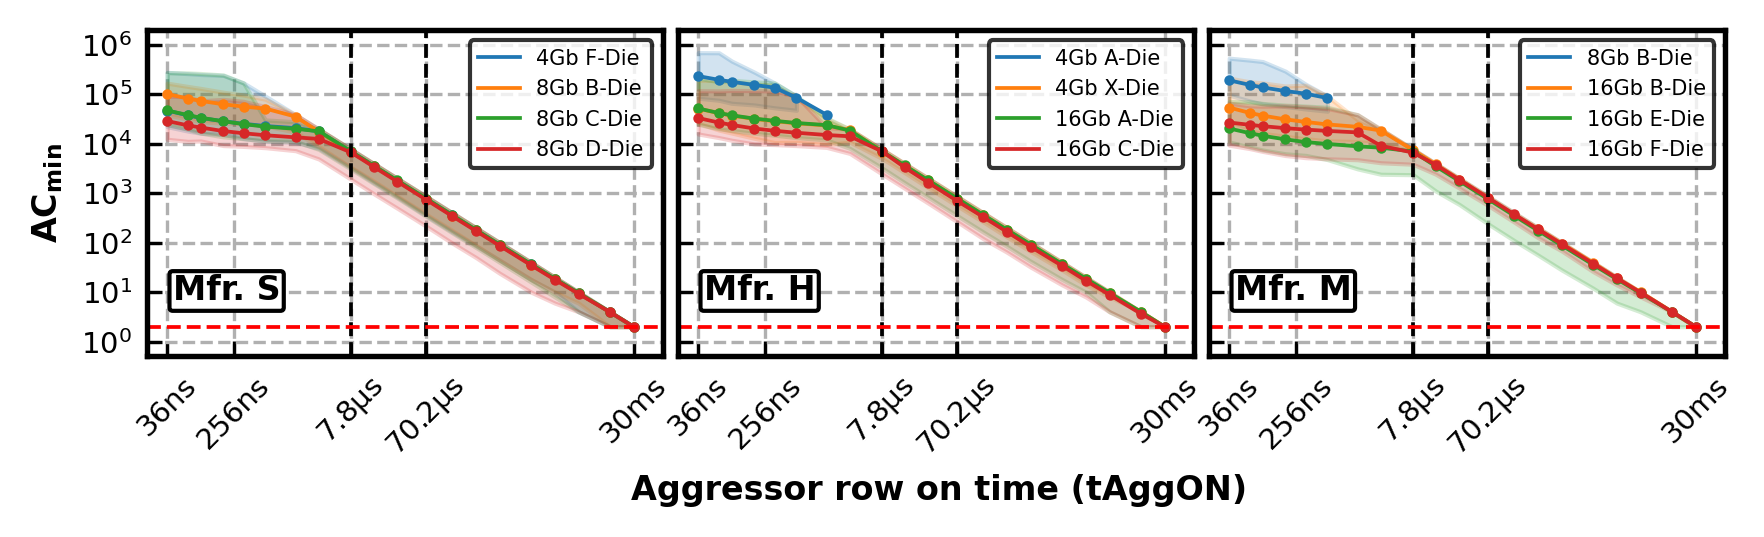

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2.0))
axs = axs.reshape(-1)

temp = 50
pattern = "double-checkered"

mfrlocs = {
  'Mfr. S': [0.05, 0.15, 'left', 'bottom'], 
  'Mfr. M': [0.05, 0.15, 'left', 'bottom'], 
  'Mfr. H': [0.05, 0.15, 'left', 'bottom']
}

for i, mfr in enumerate(mfr_order):
  data = hcf_data.loc[(hcf_data["mfr"] == mfr) & (hcf_data["pattern"] == pattern) & (hcf_data["temperature"] == temp)]
  g = sns.lineplot(data=data, x="tAggON", y="ac_min", hue="die", linewidth=0.9, ax=axs[i], errorbar=("pi", 100), hue_order=hue_orders[mfr], marker=".", markeredgecolor='none', markersize=5)
  g.legend_.set_title(None)
  # axs[i].set_title(mfr, fontsize=10, weight="bold")
  axs[i].text(mfrlocs[mfr][0], mfrlocs[mfr][1], mfr, transform=axs[i].transAxes, fontsize=8, weight="bold", va=mfrlocs[mfr][3], ha=mfrlocs[mfr][2], backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

for i, ax in enumerate(axs):
  ax.loglog()
  ax.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
  ax.set_ylim([0.5, 2000000])
  ax.tick_params(axis="y", direction="in", labelsize=7)

  ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
  ax.set_xlim([20, 70000000])
  ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"70.2$\mu$s", "30ms"], rotation=45, ha='center', fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=7)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axhline(y=2, linewidth=0.9, color='red', linestyle="dashed")

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  if i != 0:
    ax.set_yticklabels([])

  l = ax.legend(loc='upper right', ncol=1, fontsize=5, columnspacing=0.7,  edgecolor="black")
  for line in l.get_lines():
    line.set_linewidth(0.9)

axs[0].set_ylabel(r"$AC_{min}$", fontsize=8, weight="bold")
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.13, x=0.53, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("./output/Figure13.pdf", bbox_inches='tight', pad_inches=0.03)
plt.savefig("./output/Figure13.png", bbox_inches='tight', pad_inches=0.03)

## Slope

In [32]:
from scipy import stats

data = hcf_data.copy()
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()
mask = (data["tAggON"] >= 7776) & (data["pattern"] == "double-checkered") & (data["temperature"] == 50)
data = data.loc[mask]

In [33]:
for mfr in data["mfr"].unique():
  g = data.loc[data["mfr"] == mfr]
  slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(g["tAggON"]), np.log(g["ac_min"]))
  print(mfr)
  print("slope: %f    intercept: %f" % (1/slope, intercept))
  print("r-squared: %f" % r_value**2)
  print()

Mfr. H
slope: -1.009882    intercept: 17.705211
r-squared: 0.999396

Mfr. M
slope: -1.010798    intercept: 17.709350
r-squared: 0.999863

Mfr. S
slope: -1.014575    intercept: 17.626285
r-squared: 0.999857



## Figure 14
Single-sided ACmin minus double-sided ACmin at 50C (first row) and 80C (second row).

In [34]:
data = hcf_data.copy()
data = data.groupby(["mfr", "die", "module", "pattern", "temperature", "tAggON"]).mean().reset_index()
data = data.drop(["row", "hcf", "itr", "atk_time_ns"], axis=1)

data_s = data.loc[data["pattern"] == "single-checkered"]
data_d = data.loc[data["pattern"] == "double-checkered"]

data = pd.merge(left=data_s, right=data_d, how="right", on=["mfr", "die", "module", "tAggON", "temperature"], suffixes=["_s", "_d"])
data["diff"] = data["ac_min_s"] - data["ac_min_d"]

d = data.groupby(["mfr", "die", "tAggON", "temperature"]).mean().reset_index()
d = d.loc[d["diff"] < 0.0]
d = d.loc[d["tAggON"].between(186, 7776, inclusive="both")]

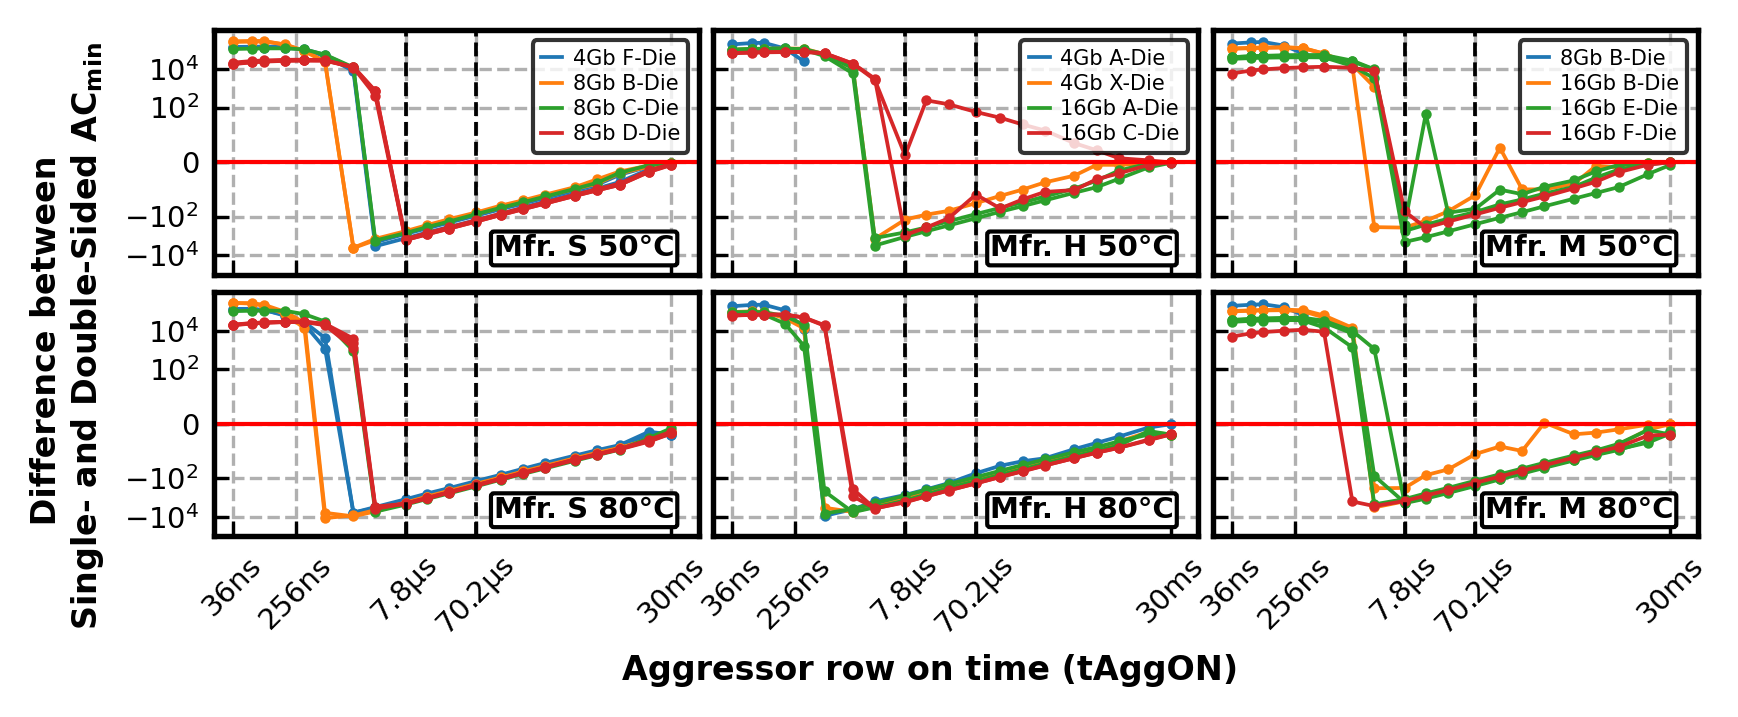

In [35]:
mfrlocs = {
  'Mfr. S': [0.95, 0.05, 'right', 'bottom'], 
  'Mfr. M': [0.95, 0.05, 'right', 'bottom'], 
  'Mfr. H': [0.95, 0.05, 'right', 'bottom']
}

fig, axs = plt.subplots(2, 3, figsize=(6, 2.6))
axs = axs.reshape(-1)
for i, mfr in enumerate(mfr_order):
  d = data.loc[(data["mfr"] == mfr) & (data["temperature"] == 50)]
  g = sns.lineplot(data=d, x="tAggON", y="diff", hue="die", units="module", linewidth=0.9, ax=axs[i],
  estimator=None, hue_order=hue_orders[mfr], marker=".", markeredgecolor='none', markersize=5)
  g.legend_.set_title(None)

  d = data.loc[(data["mfr"] == mfr) & (data["temperature"] == 80)]
  g = sns.lineplot(data=d, x="tAggON", y="diff", hue="die", units="module", linewidth=0.9, ax=axs[i + 3],
  estimator=None, hue_order=hue_orders[mfr], marker=".", markeredgecolor='none', markersize=5)
  g.legend_.set_title(None)

  # axs[i].set_title(mfr, fontsize=10, weight="bold", pad=25.0)
  # axs[i].text(s=f"50°C", x = 0.7, y = 0.85, fontweight='bold', fontsize=8, transform=axs[i].transAxes, 
  #     horizontalalignment='left',
  #     verticalalignment='bottom',
  #     color="mediumblue")
  # axs[i+3].text(s=f"80°C", x = 0.7, y = 0.85, fontweight='bold', fontsize=8, transform=axs[i + 3].transAxes, 
  #     horizontalalignment='left',
  #     verticalalignment='bottom',
  #     color="fuchsia")

  axs[i].text(mfrlocs[mfr][0], mfrlocs[mfr][1], mfr+" 50°C", transform=axs[i].transAxes, fontsize=7, weight="bold", va=mfrlocs[mfr][3], ha=mfrlocs[mfr][2], backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))
  axs[i+3].text(mfrlocs[mfr][0], mfrlocs[mfr][1], mfr+" 80°C", transform=axs[i+3].transAxes, fontsize=7, weight="bold", va=mfrlocs[mfr][3], ha=mfrlocs[mfr][2], backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))


for i, ax in enumerate(axs):
  ax.set_yscale('symlog')
  ax.set_ylim([-10E4, 10E5])
  ax.set_yticks([-10E3, -10E1, 0, 10E1, 10E3])
  ax.tick_params(axis="y", direction="in", labelsize=7)

  ax.set_xscale("log")
  ax.set_xticks([36, 256, 7813, 9*7813, 30000000])
  ax.set_xlim([20, 70000000])
  ax.set_xticklabels(["36ns", "256ns", r"$7.8\mu s$", r"$70.2\mu s$", "30ms"], rotation=45, ha='center', fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=7)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  ax.axvline(x=7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axvline(x=9*7813, linewidth=0.9, color='black', linestyle="dashed")
  ax.axhline(y=0.0, linewidth=1.0, color='red')

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

  if i != 0 and i != 3:
    ax.set_yticklabels([])
  if i < 3:
    ax.set_xticklabels([])

  # l = ax.legend(bbox_to_anchor=(0, 1.003, 1, 0.2), loc="lower left", ncol=2, fontsize=6, columnspacing=1,  edgecolor="black")
  l = ax.legend(loc="upper right", ncol=1, fontsize=5, columnspacing=0.5, edgecolor="black", handlelength=1.0, handletextpad=0.5, labelspacing=0.25)
  for line in l.get_lines():
    line.set_linewidth(0.9)

  if i >= 3:
    ax.legend().remove()

fig.supylabel("         Difference between" + "\n" + "Single- and Double-Sided $AC_{min}$", fontsize=8, weight="bold", y=0.55, x=0.04)
fig.supxlabel(r"Aggressor row on time (tAggON)", y=0.1, x=0.54, fontsize=8, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
plt.savefig("./output/Figure14.pdf", bbox_inches='tight', pad_inches=0.03)
plt.savefig("./output/Figure14.png", bbox_inches='tight', pad_inches=0.03)

In [36]:
data = hcf_data.copy()

mask = (data["tAggON"] == 1536)
data = data.loc[mask]

data = data.groupby(["mfr", "die", "pattern", "temperature", "tAggON"]).mean().reset_index().drop(["hcf", "itr", "row", "atk_time_ns"], axis=1)
data_s = data.loc[data["pattern"] == "single-checkered"].copy()
data_d = data.loc[data["pattern"] == "double-checkered"].copy()

j = pd.merge(left=data_s, right=data_d, how="right", on=["mfr", "die", "temperature", "tAggON"], suffixes=["_s", "_d"])
j["difference"] = j["ac_min_s"] - j["ac_min_d"]

j.drop(["pattern_s", "pattern_d"], axis=1, inplace=True)
j.reset_index(drop=True, inplace=True)
j.set_index(["mfr", "die", "temperature", "tAggON"], inplace=True)
j.unstack().stack(level=0)
display(j)

ac_min_s      ac_min_d    difference
mfr    die        temperature tAggON                                          
Mfr. H 16Gb A-Die 50          1536    30705.966942  23858.661448   6847.305494
                  80          1536     8207.175781  12900.922526  -4693.746745
       16Gb C-Die 50          1536    33508.936937  15057.791585  18451.145352
                  80          1536    14441.980306  15048.395375   -606.415069
       4Gb A-Die  50          1536             NaN  38674.000000           NaN
                  80          1536    32611.884615  36551.500000  -3939.615385
       4Gb X-Die  50          1536    34213.747059  23572.555773  10641.191286
                  80          1536     9209.303385  14593.204168  -5383.900783
Mfr. M 16Gb B-Die 50          1536    35475.322382  22042.664057  13432.658325
                  80          1536    29484.774242  21139.020548   8345.753694
       16Gb E-Die 50          1536    27723.111640   8877.508631  18845.603009
                  80          1536    14909.909831   8874.140408   6035.769423
       16Gb F-Die 50          1536    28233.106557  16984.379681  11248.726876
                  80          1536    12510.041992  14080.421875  -1570.379883
       8Gb B-Die  80          1536             NaN  38674.000000           NaN
Mfr. S 4Gb F-Die  50          1536    29731.149233  20757.540346   8973.608887
                  80          1536    10786.724284  16689.369466  -5902.645182
       8Gb B-Die  50          1536    31266.661125  35477.107163  -4210.446037
                  80          1536    17296.322103  25995.410593  -8699.088490
       8Gb C-Die  50          1536    31883.557155  20116.449902  11767.107254
                  80          1536    21644.356771  20761.353575    883.003196
       8Gb D-Die  50          1536    25580.305307  13497.670143  12082.635164
                  80          1536    16413.600803  13922.047324   2491.553479

## Figure 16
BER of the representative Mfr. S 8Gb D-Die; Single-(top row) and double-sided (bottom row) RowPress-ONOFF pattern at 50C (left column) and 80C (right column).

In [37]:
ftber = ftber_data.copy()
mask =  (ftber["temperature"] == 50) | (ftber["temperature"] == 80)
mask &= (ftber["pattern"] == "single-checkered") | (ftber["pattern"] == "double-checkered")
ftber = ftber[mask]
ftber["ber"] = ftber["bitflips"] / (8 * 1024 * 8)

ftber.drop(columns=["itr"], inplace=True)
ftber = ftber.loc[ftber["ber"] > 0]

In [38]:
ftber.pattern.unique()

array(['double-checkered', 'single-checkered'], dtype=object)

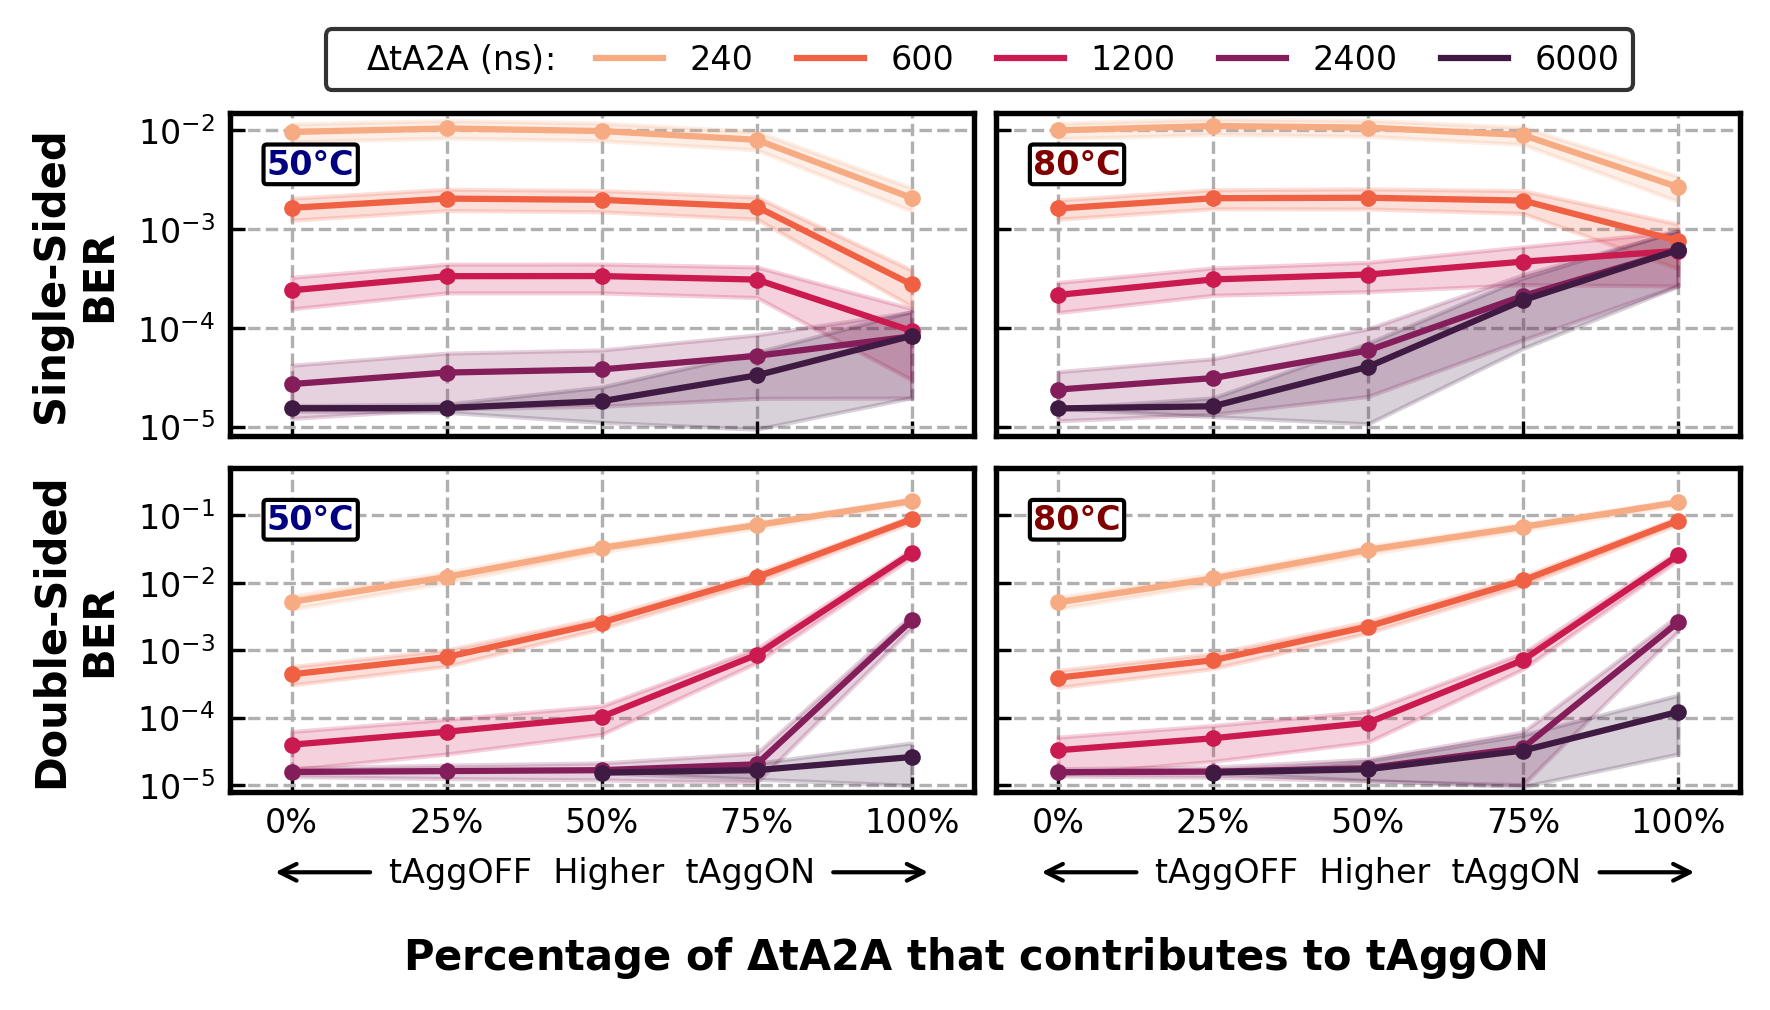

In [39]:
temps = ftber.temperature.unique()
temps.sort()
patterns = ftber.pattern.unique()
patterns.sort()
patterns = patterns[::-1]

fig, axs = plt.subplots(2, 2, figsize=(6, 3.2))
axs = axs.reshape(-1)

for i, pattern in enumerate(patterns):
  for j, temp in enumerate(temps):
    mask = (ftber["die"] == "8Gb D-Die") & (ftber["pattern"] == pattern) & (ftber["temperature"] == temp) & (ftber["extra_delay_ns"].between(240, 6000, inclusive="both"))
    data = ftber.loc[mask].copy()
    data["extra_delay_ns"] = data.extra_delay_ns.astype('category')
    g = sns.lineplot(data=data, x="tAggON_ratio", y="ber", hue="extra_delay_ns", ax=axs[j + i * 2], palette="rocket_r", marker=".", markeredgecolor='none', markersize=8, ci="sd")
    # if i == 0:
    #   g.legend_.set_title("tA2A (ns)")
    #   sns.move_legend(axs[i], bbox_to_anchor=(0, 1.003, 1.2, 0.2), loc="lower left", ncol=5, edgecolor="black", fontsize=6)
    # else:
    g.legend_.remove()
    if (temp == 80):
      axs[j + i * 2].text(0.05, 0.79, f"{temp}°C", transform=axs[j + i * 2].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'), color="#800000")
    else:
      axs[j + i * 2].text(0.05, 0.79, f"{temp}°C", transform=axs[j + i * 2].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'), color="#000080")
      # axs[j].set_title(f"{temp}°C", fontsize=10, weight="bold", color="mediumblue")
    # if temp == 80:
    #   # axs[j].set_title(f"{temp}°C", fontsize=10, weight="bold", color="fuchsia")
    #   axs[i].text(0.05, 0.85, f"{temp}°C", transform=axs[i].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

for i, ax in enumerate(axs):
  ax.set_yscale("log")
  
  if i < 2:
    ax.set_yticks([10E-6, 10E-5, 10E-4, 10E-3, 10E-2])
    ax.set_ylim([8*10E-7, 1.5*10E-3])
  else:
    ax.set_yticks([10E-6, 10E-5, 10E-4, 10E-3, 10E-2, 10E-1])
    ax.set_ylim([8*10E-7, 5*10E-2])
  ax.tick_params(axis="y", direction="in", labelsize=8)

  ax.set_xticks([0.00, 0.25, 0.50, 0.75, 1.00])
  ax.set_xlim([-0.1, 1.1])
  ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"], fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=8)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  if i < 2:
    ax.set_xticklabels([])
  if i % 2 != 0:
    ax.set_yticklabels([])


  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)



# lines_labels = [axs[0].get_legend_handles_labels()]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

h, l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]
handles = ph + h
labels = [r'$\Delta$tA2A (ns):'] + l
l = fig.legend(handles, labels, bbox_to_anchor=(0.18, 0.96, 0.5, 0.1), loc="lower left", ncol=6, fontsize=8, columnspacing=1.3, edgecolor="black")
# l.get_title().set_fontsize(8)
for vpack in l._legend_handle_box.get_children()[:1]:
  for hpack in vpack.get_children():
    hpack.get_children()[0].set_width(0)

axs[2].annotate("", xy=(0.8 , -0.25), xycoords='axes fraction', xytext=(0.95, -0.25), arrowprops=dict(arrowstyle="<-", linewidth=1.0))
axs[2].annotate("", xy=(0.05, -0.25), xycoords='axes fraction', xytext=(0.2 , -0.25), arrowprops=dict(arrowstyle="->", linewidth=1.0))
axs[2].text(s=f"tAggOFF  Higher  tAggON", x=0.5, y=-0.25, fontsize=8, transform=axs[2].transAxes, 
    horizontalalignment='center',
    verticalalignment='center')

axs[3].annotate("", xy=(0.8 , -0.25), xycoords='axes fraction', xytext=(0.95, -0.25), arrowprops=dict(arrowstyle="<-", linewidth=1.0))
axs[3].annotate("", xy=(0.05 , -0.25), xycoords='axes fraction', xytext=(0.2, -0.25), arrowprops=dict(arrowstyle="->", linewidth=1.0))
axs[3].text(s=f"tAggOFF  Higher  tAggON", x=0.5, y=-0.25, fontsize=8, transform=axs[3].transAxes, 
    horizontalalignment='center',
    verticalalignment='center')

# fig.suptitle(f"Mfr. S\n8Gb D-Die", fontsize=10, weight="bold", x=0.3, y=1.00)
axs[0].set_ylabel(r"Single-Sided" + "\n" + "BER", fontsize=10, weight="bold")
axs[2].set_ylabel(r"Double-Sided" + "\n" + "BER", fontsize=10, weight="bold")
fig.supxlabel(r"Percentage of $\Delta$tA2A that contributes to tAggON", y=0.05, x=0.55, fontsize=10, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.10)
plt.savefig(f"./output/Figure16.pdf", bbox_inches='tight', pad_inches=0.012)
plt.savefig(f"./output/Figure16.png", bbox_inches='tight', pad_inches=0.012)

Processing Mfr. H 16Gb A-Die...
Processing Mfr. H 4Gb A-Die...
Processing Mfr. H 4Gb X-Die...
Processing Mfr. H 16Gb C-Die...


KeyboardInterrupt: 

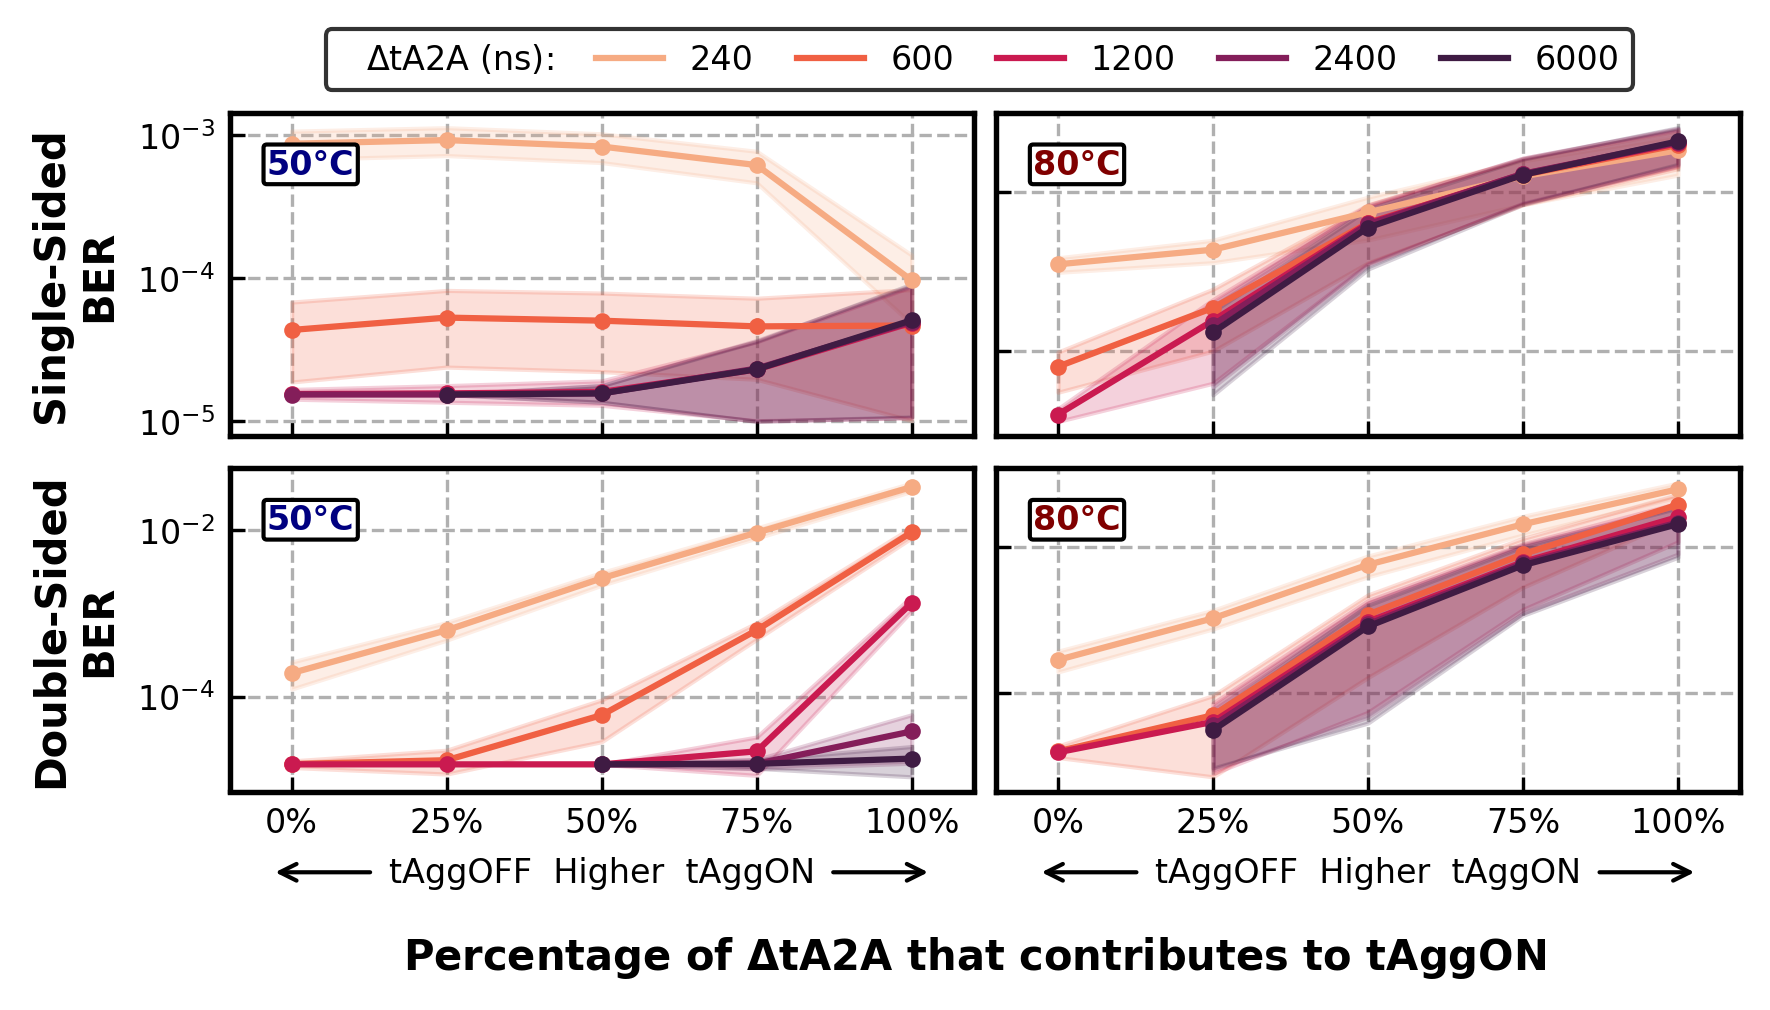

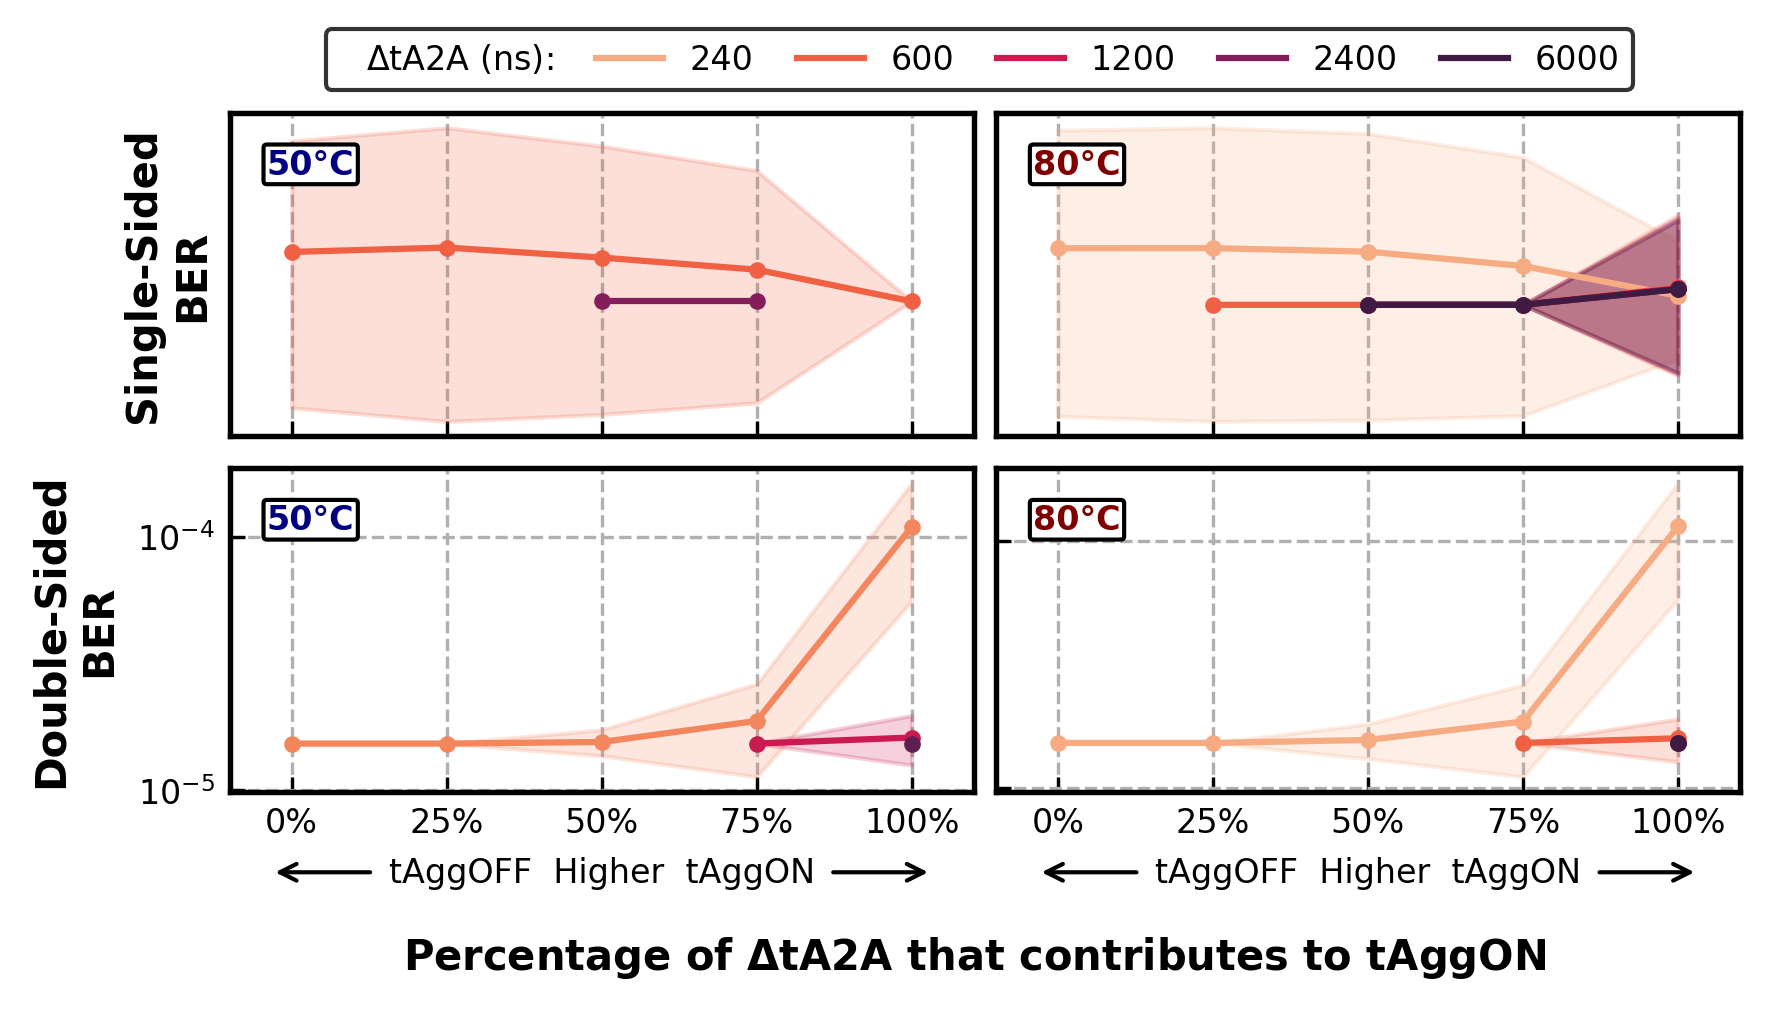

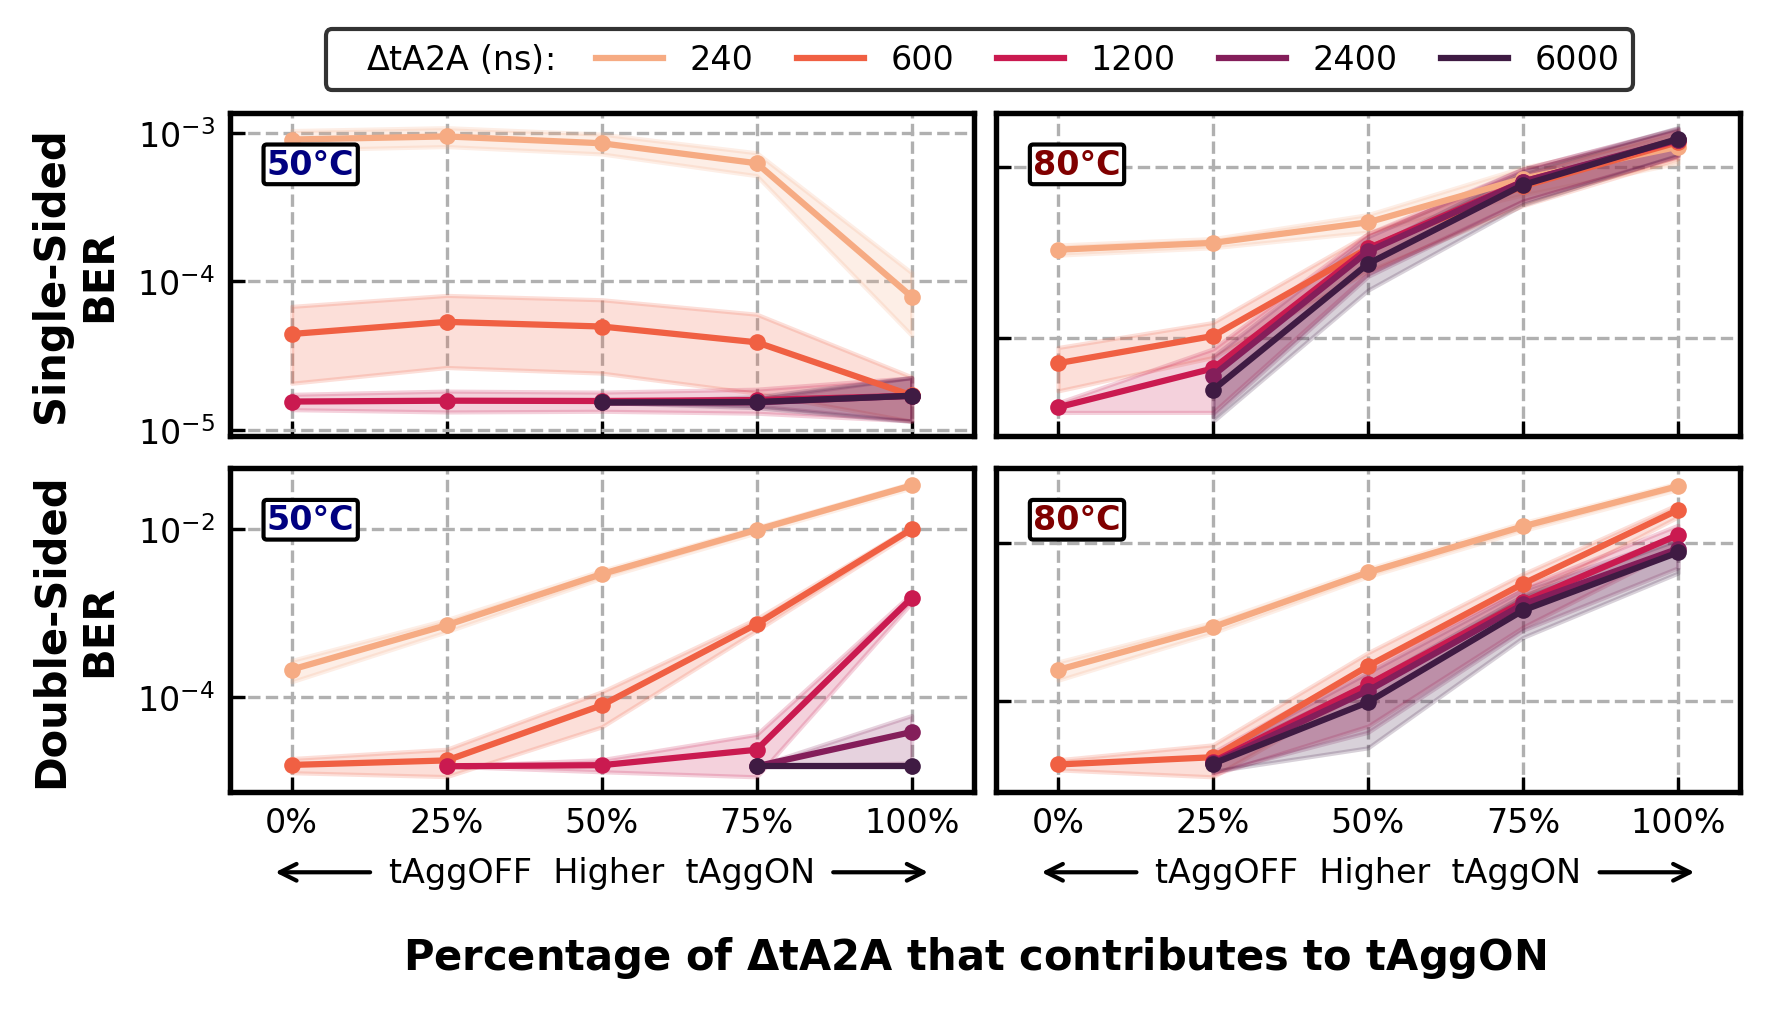

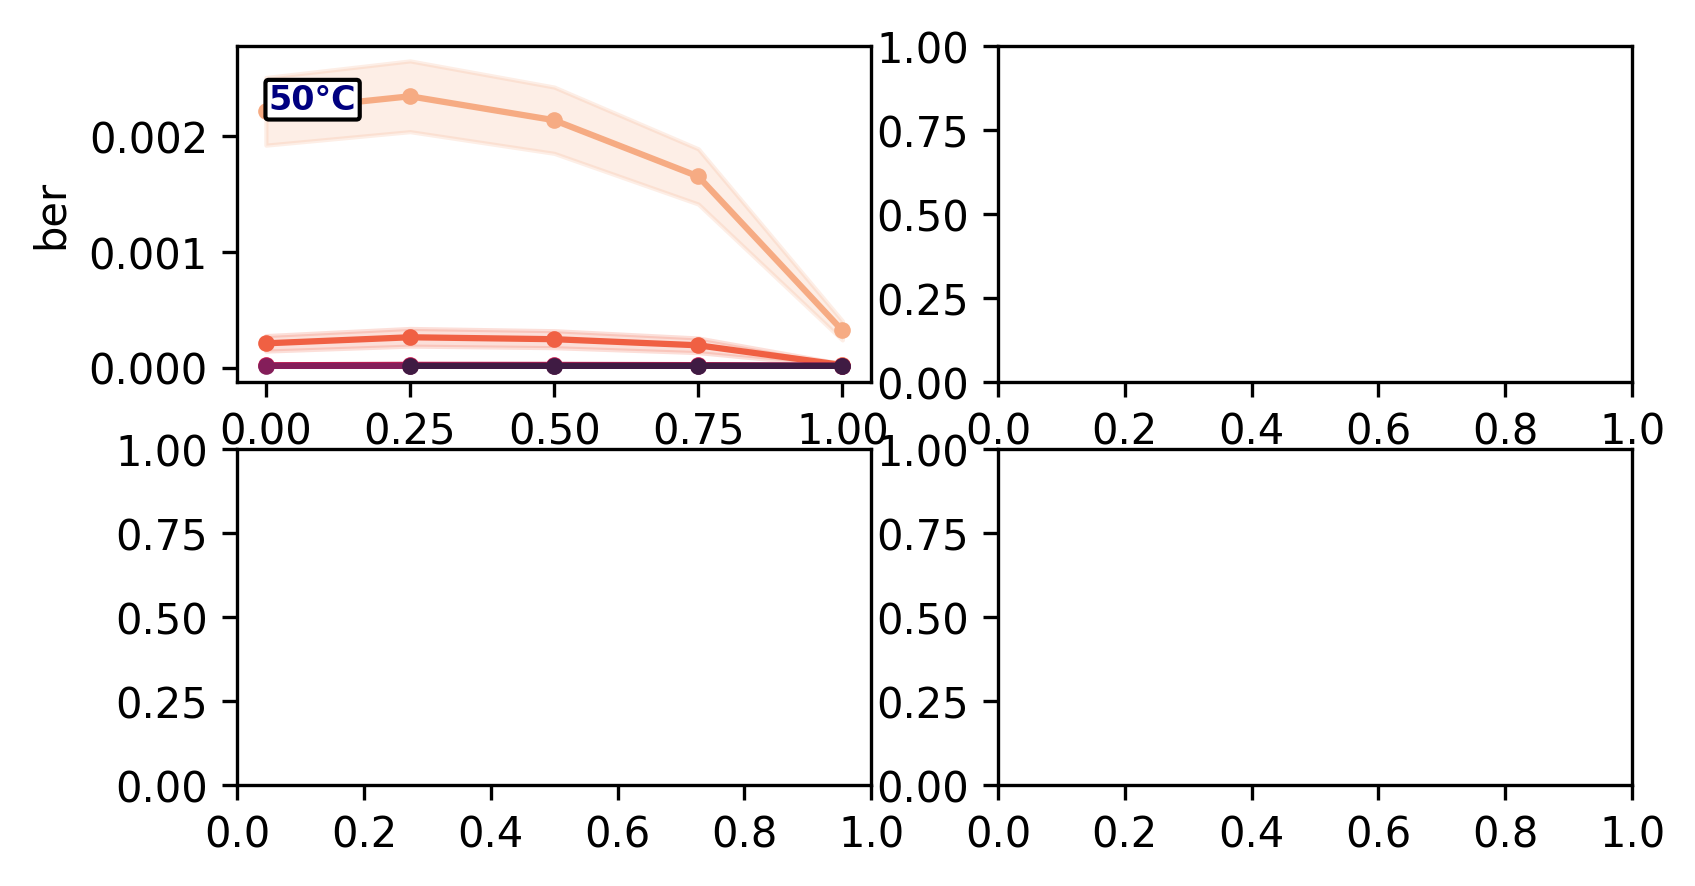

In [40]:
temps = ftber.temperature.unique()
temps.sort()
patterns = ftber.pattern.unique()
patterns.sort()
patterns = patterns[::-1]

for mfr in ftber["mfr"].unique():
  for die in ftber.loc[ftber["mfr"] == mfr]["die"].unique():
    fig, axs = plt.subplots(2, 2, figsize=(6, 3.2))
    axs = axs.reshape(-1)
    print(f"Processing {mfr} {die}...")
    for i, pattern in enumerate(patterns):
      for j, temp in enumerate(temps):
        mask = (ftber["mfr"] == mfr) & (ftber["die"] == die) & (ftber["pattern"] == pattern) & (ftber["temperature"] == temp) & (ftber["extra_delay_ns"].between(240, 6000, inclusive="both"))
        data = ftber.loc[mask].copy()
        data["extra_delay_ns"] = data.extra_delay_ns.astype('category')
        g = sns.lineplot(data=data, x="tAggON_ratio", y="ber", hue="extra_delay_ns", ax=axs[j + i * 2], palette="rocket_r", marker=".", markeredgecolor='none', markersize=8, ci="sd")
        # if i == 0:
        #   g.legend_.set_title("tA2A (ns)")
        #   sns.move_legend(axs[i], bbox_to_anchor=(0, 1.003, 1.2, 0.2), loc="lower left", ncol=5, edgecolor="black", fontsize=6)
        # else:
        if g.legend_ != None:
          g.legend_.remove()
        if (temp == 80):
          axs[j + i * 2].text(0.05, 0.79, f"{temp}°C", transform=axs[j + i * 2].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'), color="#800000")
        else:
          axs[j + i * 2].text(0.05, 0.79, f"{temp}°C", transform=axs[j + i * 2].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'), color="#000080")
          # axs[j].set_title(f"{temp}°C", fontsize=10, weight="bold", color="mediumblue")
        # if temp == 80:
        #   # axs[j].set_title(f"{temp}°C", fontsize=10, weight="bold", color="fuchsia")
        #   axs[i].text(0.05, 0.85, f"{temp}°C", transform=axs[i].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

    for i, ax in enumerate(axs):
      ax.set_yscale("log")
      
      # if i < 2:
      #   ax.set_yticks([10E-6, 10E-5, 10E-4, 10E-3, 10E-2])
      #   ax.set_ylim([8*10E-7, 1.5*10E-3])
      # else:
      #   ax.set_yticks([10E-6, 10E-5, 10E-4, 10E-3, 10E-2, 10E-1])
      #   ax.set_ylim([8*10E-7, 5*10E-2])
      ax.tick_params(axis="y", direction="in", labelsize=8)

      ax.set_xticks([0.00, 0.25, 0.50, 0.75, 1.00])
      ax.set_xlim([-0.1, 1.1])
      ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"], fontsize=7)
      ax.tick_params(axis="x",direction="in", labelsize=8)

      ax.minorticks_off()
      ax.set(xlabel=None, ylabel=None)
      ax.grid(linestyle='--')
      ax.set_axisbelow(True)

      if i < 2:
        ax.set_xticklabels([])
      if i % 2 != 0:
        ax.set_yticklabels([])


      for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)



    # lines_labels = [axs[0].get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    h, l = ax.get_legend_handles_labels()
    ph = [plt.plot([],marker="", ls="")[0]]
    handles = ph + h
    labels = [r'$\Delta$tA2A (ns):'] + l
    l = fig.legend(handles, labels, bbox_to_anchor=(0.18, 0.96, 0.5, 0.1), loc="lower left", ncol=6, fontsize=8, columnspacing=1.3, edgecolor="black")
    # l.get_title().set_fontsize(8)
    for vpack in l._legend_handle_box.get_children()[:1]:
      for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(0)

    axs[2].annotate("", xy=(0.8 , -0.25), xycoords='axes fraction', xytext=(0.95, -0.25), arrowprops=dict(arrowstyle="<-", linewidth=1.0))
    axs[2].annotate("", xy=(0.05, -0.25), xycoords='axes fraction', xytext=(0.2 , -0.25), arrowprops=dict(arrowstyle="->", linewidth=1.0))
    axs[2].text(s=f"tAggOFF  Higher  tAggON", x=0.5, y=-0.25, fontsize=8, transform=axs[2].transAxes, 
        horizontalalignment='center',
        verticalalignment='center')

    axs[3].annotate("", xy=(0.8 , -0.25), xycoords='axes fraction', xytext=(0.95, -0.25), arrowprops=dict(arrowstyle="<-", linewidth=1.0))
    axs[3].annotate("", xy=(0.05 , -0.25), xycoords='axes fraction', xytext=(0.2, -0.25), arrowprops=dict(arrowstyle="->", linewidth=1.0))
    axs[3].text(s=f"tAggOFF  Higher  tAggON", x=0.5, y=-0.25, fontsize=8, transform=axs[3].transAxes, 
        horizontalalignment='center',
        verticalalignment='center')

    # fig.suptitle(f"Mfr. S\n8Gb D-Die", fontsize=10, weight="bold", x=0.3, y=1.00)
    axs[0].set_ylabel(r"Single-Sided" + "\n" + "BER", fontsize=10, weight="bold")
    axs[2].set_ylabel(r"Double-Sided" + "\n" + "BER", fontsize=10, weight="bold")
    fig.supxlabel(r"Percentage of $\Delta$tA2A that contributes to tAggON", y=0.05, x=0.55, fontsize=10, weight="bold")
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.03, hspace=0.10)
    plt.savefig(f"./output/allONOFF/{mfr}_{die}.pdf", bbox_inches='tight', pad_inches=0.012)
    plt.savefig(f"./output/allONOFF/{mfr}_{die}.png", bbox_inches='tight', pad_inches=0.012)

In [ ]:
temps = ftber.temperature.unique()
temps.sort()
patterns = ftber.pattern.unique()
patterns.sort()
patterns = patterns[::-1]

fig, axs = plt.subplots(2, 2, figsize=(6, 3.2))
axs = axs.reshape(-1)

for i, pattern in enumerate(patterns):
  for j, temp in enumerate(temps):
    mask = (ftber["die"] == "8Gb D-Die") & (ftber["pattern"] == pattern) & (ftber["temperature"] == temp) & (ftber["extra_delay_ns"].between(240, 6000, inclusive="both"))
    data = ftber.loc[mask].copy()
    data["extra_delay_ns"] = data.extra_delay_ns.astype('category')
    g = sns.lineplot(data=data, x="tAggON_ratio", y="ber", hue="extra_delay_ns", ax=axs[j + i * 2], palette="rocket_r", marker=".", markeredgecolor='none', markersize=8, ci="sd")
    # if i == 0:
    #   g.legend_.set_title("tA2A (ns)")
    #   sns.move_legend(axs[i], bbox_to_anchor=(0, 1.003, 1.2, 0.2), loc="lower left", ncol=5, edgecolor="black", fontsize=6)
    # else:
    g.legend_.remove()
    if (temp == 80):
      axs[j + i * 2].text(0.05, 0.79, f"{temp}°C", transform=axs[j + i * 2].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'), color="#800000")
    else:
      axs[j + i * 2].text(0.05, 0.79, f"{temp}°C", transform=axs[j + i * 2].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'), color="#000080")
      # axs[j].set_title(f"{temp}°C", fontsize=10, weight="bold", color="mediumblue")
    # if temp == 80:
    #   # axs[j].set_title(f"{temp}°C", fontsize=10, weight="bold", color="fuchsia")
    #   axs[i].text(0.05, 0.85, f"{temp}°C", transform=axs[i].transAxes, fontsize=8, weight="bold", va="bottom", ha="left", backgroundcolor="white", bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1'))

for i, ax in enumerate(axs):
  ax.set_yscale("log")
  
  if i < 2:
    ax.set_yticks([10E-6, 10E-5, 10E-4, 10E-3, 10E-2])
    ax.set_ylim([8*10E-7, 1.5*10E-3])
  else:
    ax.set_yticks([10E-6, 10E-5, 10E-4, 10E-3, 10E-2, 10E-1])
    ax.set_ylim([8*10E-7, 5*10E-2])
  ax.tick_params(axis="y", direction="in", labelsize=8)

  ax.set_xticks([0.00, 0.25, 0.50, 0.75, 1.00])
  ax.set_xlim([-0.1, 1.1])
  ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"], fontsize=7)
  ax.tick_params(axis="x",direction="in", labelsize=8)

  ax.minorticks_off()
  ax.set(xlabel=None, ylabel=None)
  ax.grid(linestyle='--')
  ax.set_axisbelow(True)

  if i < 2:
    ax.set_xticklabels([])
  if i % 2 != 0:
    ax.set_yticklabels([])


  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)



# lines_labels = [axs[0].get_legend_handles_labels()]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

h, l = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]
handles = ph + h
labels = [r'$\Delta$tA2A (ns):'] + l
l = fig.legend(handles, labels, bbox_to_anchor=(0.18, 0.96, 0.5, 0.1), loc="lower left", ncol=6, fontsize=8, columnspacing=1.3, edgecolor="black")
# l.get_title().set_fontsize(8)
for vpack in l._legend_handle_box.get_children()[:1]:
  for hpack in vpack.get_children():
    hpack.get_children()[0].set_width(0)

axs[2].annotate("", xy=(0.8 , -0.25), xycoords='axes fraction', xytext=(0.95, -0.25), arrowprops=dict(arrowstyle="<-", linewidth=1.0))
axs[2].annotate("", xy=(0.05, -0.25), xycoords='axes fraction', xytext=(0.2 , -0.25), arrowprops=dict(arrowstyle="->", linewidth=1.0))
axs[2].text(s=f"tAggOFF  Higher  tAggON", x=0.5, y=-0.25, fontsize=8, transform=axs[2].transAxes, 
    horizontalalignment='center',
    verticalalignment='center')

axs[3].annotate("", xy=(0.8 , -0.25), xycoords='axes fraction', xytext=(0.95, -0.25), arrowprops=dict(arrowstyle="<-", linewidth=1.0))
axs[3].annotate("", xy=(0.05 , -0.25), xycoords='axes fraction', xytext=(0.2, -0.25), arrowprops=dict(arrowstyle="->", linewidth=1.0))
axs[3].text(s=f"tAggOFF  Higher  tAggON", x=0.5, y=-0.25, fontsize=8, transform=axs[3].transAxes, 
    horizontalalignment='center',
    verticalalignment='center')

# fig.suptitle(f"Mfr. S\n8Gb D-Die", fontsize=10, weight="bold", x=0.3, y=1.00)
axs[0].set_ylabel(r"Single-Sided" + "\n" + "BER", fontsize=10, weight="bold")
axs[2].set_ylabel(r"Double-Sided" + "\n" + "BER", fontsize=10, weight="bold")
fig.supxlabel(r"Percentage of $\Delta$tA2A that contributes to tAggON", y=0.05, x=0.55, fontsize=10, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.10)
plt.savefig(f"./output/Figure16.pdf", bbox_inches='tight', pad_inches=0.012)
plt.savefig(f"./output/Figure16.png", bbox_inches='tight', pad_inches=0.012)

In [ ]:
mask = (ftber["die"] == "8Gb D-Die") & (ftber["pattern"] == "single-checkered")  & (ftber["extra_delay_ns"].between(240, 6000, inclusive="both"))
d = ftber.loc[mask].copy()
display(d.groupby(["pattern",	"temperature", "extra_delay_ns", "tAggON_ratio"]).mean())

hc        ac  \
pattern          temperature extra_delay_ns tAggON_ratio                       
single-checkered 50          240            0.00          204082.0  204082.0   
                                            0.25          204082.0  204082.0   
                                            0.50          204082.0  204082.0   
                                            0.75          204082.0  204082.0   
                                            1.00          204082.0  204082.0   
                             600            0.00           91744.0   91744.0   
                                            0.25           91744.0   91744.0   
                                            0.50           91744.0   91744.0   
                                            0.75           91744.0   91744.0   
                                            1.00           91744.0   91744.0   
                             1200           0.00           47847.0   47847.0   
                                            0.25           47847.0   47847.0   
                                            0.50           47847.0   47847.0   
                                            0.75           47847.0   47847.0   
                                            1.00           47847.0   47847.0   
                             2400           0.00           24450.0   24450.0   
                                            0.25           24450.0   24450.0   
                                            0.50           24450.0   24450.0   
                                            0.75           24450.0   24450.0   
                                            1.00           24450.0   24450.0   
                             6000           0.00            9911.0    9911.0   
                                            0.25            9911.0    9911.0   
                                            0.50            9911.0    9911.0   
                                            0.75            9911.0    9911.0   
                                            1.00            9911.0    9911.0   
                 80          240            0.00          204082.0  204082.0   
                                            0.25          204082.0  204082.0   
                                            0.50          204082.0  204082.0   
                                            0.75          204082.0  204082.0   
                                            1.00          204082.0  204082.0   
                             600            0.00           91744.0   91744.0   
                                            0.25           91744.0   91744.0   
                                            0.50           91744.0   91744.0   
                                            0.75           91744.0   91744.0   
                                            1.00           91744.0   91744.0   
                             1200           0.00           47847.0   47847.0   
                                            0.25           47847.0   47847.0   
                                            0.50           47847.0   47847.0   
                                            0.75           47847.0   47847.0   
                                            1.00           47847.0   47847.0   
                             2400           0.00           24450.0   24450.0   
                                            0.25           24450.0   24450.0   
                                            0.50           24450.0   24450.0   
                                            0.75           24450.0   24450.0   
                                            1.00           24450.0   24450.0   
                             6000           0.00            9911.0    9911.0   
                                            0.25            9911.0    9911.0   
                                            0.50            9911.0    9911.0   
                                            0.75            9911

## Extract Examplar AC_min Reduction for Mitigation Evaluation

In [ ]:
hcf = hcf_data.copy()
adf = hcf.loc[(hcf["mfr"] == 'Mfr. S') & (hcf["die"] == "8Gb B-Die")& (hcf["tAggON"] < 2000)]
# get mean ac_min for every taggon value
adf = adf.groupby(["tAggON", "pattern", "temperature"]).mean().reset_index()
adf = adf.groupby(["tAggON"]).min().reset_index()

# the factor between acmin of taggon = 36 and all other taggons
factor = adf.loc[adf["tAggON"] != 36, "ac_min"] / adf.loc[adf["tAggON"] == 36, "ac_min"].values[0]
# add it as new column
adf["normalized_acmin"] = factor

# new df that does not contain taggon = 36
adf2 = adf.loc[adf["tAggON"] != 36]
adf2 = adf2.loc[adf2["tAggON"].isin([66, 96, 186, 336, 636])]
display(adf2.drop(["pattern", "temperature", "row", "itr", "atk_time_ns"], axis=1))

tAggON           hcf        ac_min  normalized_acmin
1      66  41122.754395  82245.508789          0.809552
2      96  36827.037760  73654.075521          0.724986
3     186  31457.147786  62914.295573          0.619273
4     336  28234.760579  56469.521159          0.555836
5     636  25648.648112  42661.423828          0.419922

# Section VII

## Figure 18
Number of 64-bit words with different bitflip counts for single-sided (left) and double-sided (right) RowPress.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
def get_bfs_per_word(output_filename):
    output_file = open(output_filename)
    data = output_file.readlines()[1:]
    output_file.close()
    bfs_dict = {}
    if(data == [] or data == ['No bitflips\n']):
        return bfs_dict
    for line, i in zip(data, range(len(data))):
        bfs_dict[i + 1] = int(line.split(',')[1])
    return bfs_dict

def get_df_ber(output_folder, type):
    bfs_list = []
    for data_file in os.listdir(output_folder):
        if(not type in data_file):
            continue
        module = data_file.split('_')[0]
        vendor = module_to_annon_mfr(module)
        die = module_to_die(module)
        bfs_dic = get_bfs_per_word(output_folder + "/" + data_file)
        for bfs, num_words in bfs_dic.items():
            bfs_list.append((bfs, num_words, module, vendor, die))

    df = pd.DataFrame(bfs_list, columns=['bfs', 'num of words', 'module', 'vendor', 'die'])
    df.loc[df['bfs'] <= 2, 'bfs'] = 0
    df.loc[df['bfs'] > 8, 'bfs'] = 2
    df.loc[df['bfs'] > 2, 'bfs'] = 1
    df = df.groupby(['bfs', 'module', 'vendor', 'die']).sum().reset_index()
    df.loc[df['bfs'] == 0, 'bfs'] = '1-2'
    df.loc[df['bfs'] == 1, 'bfs'] = '3-8'
    df.loc[df['bfs'] == 2, 'bfs'] = '>8'
    return df

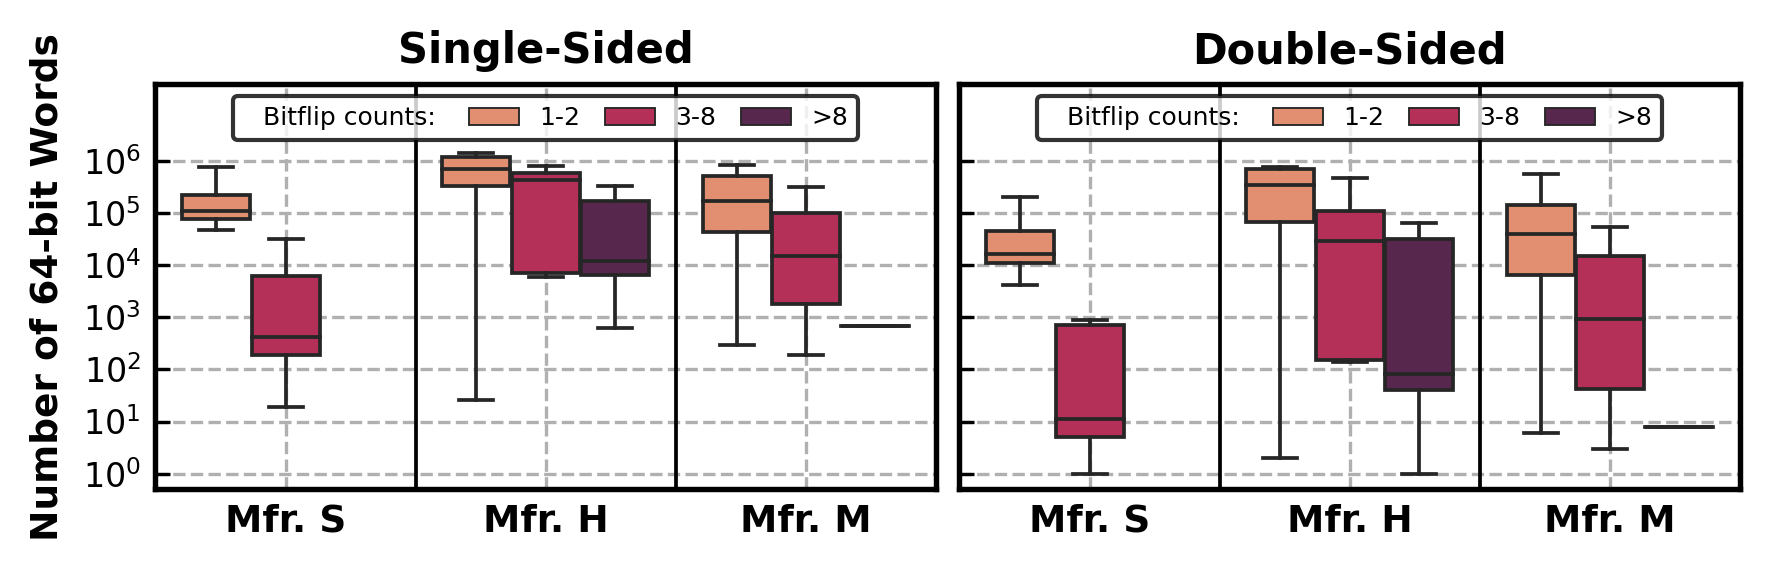

In [ ]:
output_folder = "./output/"
if not os.path.exists(output_folder):
   os.makedirs(output_folder)

folder = "../processed_data/ecc/"
ecc_df = pd.DataFrame(columns=['bfs', 'num of words', 'module', 'vendor', 'die', 'type'])
for type in ["double", "single"]:
    df = get_df_ber(folder, type)
    df['type'] = type
    ecc_df = ecc_df.append(df)
fig, axs = plt.subplots(1, 2, figsize=(6, 2.0))
axs = axs.reshape(-1)
sns.color_palette("rocket")

ecc_df = ecc_df.sort_values('vendor')
mfrs = ['Mfr. S', 'Mfr. H', 'Mfr. M']

g = sns.boxplot(data=ecc_df.loc[ecc_df["type"] == 'single'], x="vendor", y="num of words", hue="bfs", ax=axs[0], 
                linewidth=0.9, whis=[0, 100], palette='rocket_r', hue_order=['1-2', '3-8', '>8'], order=mfrs)
g.legend_.set_title(None)
g = sns.boxplot(data=ecc_df.loc[ecc_df["type"] == 'double'], x="vendor", y="num of words", hue="bfs", ax=axs[1], 
                linewidth=0.9, whis=[0, 100], palette='rocket_r', hue_order=['1-2', '3-8', '>8'], order=mfrs)
g.legend_.set_title(None)

axs[0].set_title('Single-Sided', fontsize=10, weight="bold", pad=5, y=1.0)
axs[1].set_title('Double-Sided', fontsize=10, weight="bold", pad=5, y=1.0)

for i, ax in enumerate(axs):
    ax.set_yscale("log")
    ax.set_yticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_ylim([0.5, 30000000])
    ax.tick_params(axis="y", direction="in", labelsize=8)
    ax.tick_params(axis="x",length=0)

    ax.set_xticks(range(3), weight='bold')
    ax.set_xticklabels(mfrs, ha='center', fontsize=9, fontweight='bold')
    ax.minorticks_off()
    ax.set(xlabel=None, ylabel=None)
    ax.grid(linestyle='--')
    ax.set_axisbelow(True)
    ax.axvline(x=0.5, linewidth=0.9, color='black')
    ax.axvline(x=1.5, linewidth=0.9, color='black')

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)

if i != 0 and i != 3:
    ax.set_yticklabels([])

for ax in axs:
    h, l = ax.get_legend_handles_labels() # Extracting handles and labels
    ph = [patches.Rectangle((0,0), 0, 0, linewidth=1, edgecolor=None, facecolor='none')]

    handles = ph + h
    labels = ["Bitflip counts: "] + l  # Merging labels

    l = ax.legend(handles, labels, ncol=4, loc='upper center', 
                fontsize=6, columnspacing=1, bbox_to_anchor=(0.5, 0.9999999), 
                edgecolor="black")
    for vpack in l._legend_handle_box.get_children()[:1]:
        for hpack in vpack.get_children():
            hpack.get_children()[0].set_width(0)

axs[0].set_ylabel(r"Number of 64-bit Words", fontsize=9, weight="bold")
fig.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.07)
title = "Figure18"
plt.savefig(output_folder + title + ".pdf", bbox_inches='tight', pad_inches=0.01)
plt.savefig(output_folder + title + ".png", bbox_inches='tight', pad_inches=0.01)

In [ ]:
def get_bfs_per_word(output_filename):
    output_file = open(output_filename)
    data = output_file.readlines()[1:]
    output_file.close()
    bfs_dict = {}
    if(data == [] or data == ['No bitflips\n']):
        return bfs_dict
    for line, i in zip(data, range(len(data))):
        bfs_dict[i + 1] = int(line.split(',')[1])
    return bfs_dict

def get_max_bfs(data_file):
    bfs_dic = get_bfs_per_word('../processed_data/ecc/' + data_file)
    if(len(bfs_dic.items()) == 0):
        return 0
    else:
        return max(bfs_dic.keys())

max_bfs = -1
for data_file in os.listdir("../processed_data/ecc/"):
    bfs = get_max_bfs(data_file)
    if(bfs > max_bfs):
        max_bfs = bfs
print("Maximum number of bitflips per ecc word: " + str(max_bfs))

Maximum number of bitflips per ecc word: 25


In [ ]:
ecc_df2 = ecc_df.copy()
ecc_df2 = ecc_df2.drop(ecc_df2[ecc_df2['bfs'] == '1-2'].index)
ecc_df2.loc[ecc_df2['bfs'] == '3-8', 'bfs'] = '3-8+'
ecc_df2.loc[ecc_df2['bfs'] == '>8', 'bfs'] = '3-8+'
ecc_df2 = ecc_df2.groupby(['bfs', 'module', 'vendor', 'die', 'type']).sum().reset_index()

ecc_df2['max_vendor'] = ecc_df2.groupby(['vendor'])['num of words'].transform(max)
ecc_df2 = ecc_df2.drop(ecc_df2[ecc_df2['num of words'] != ecc_df2['max_vendor']].index)
ecc_df2['num of words'] = ecc_df2['num of words'] / (3*1024*64*1024/64)*100 

print("Maximum percentage of words with 3-8+ bitflips for Mfr. S: " + str(ecc_df2.loc[ecc_df2['vendor'] == 'Mfr. S']['num of words'].values[0]) + "%")
print("Maximum percentage of words with 3-8+ bitflips for Mfr. H: " + str(ecc_df2.loc[ecc_df2['vendor'] == 'Mfr. H']['num of words'].values[0]) + "%")
print("Maximum percentage of words with 3-8+ bitflips for Mfr. M: " + str(ecc_df2.loc[ecc_df2['vendor'] == 'Mfr. M']['num of words'].values[0]) + "%")

Maximum percentage of words with 3-8+ bitflips for Mfr. S: 0.9894371032714844%
Maximum percentage of words with 3-8+ bitflips for Mfr. H: 35.77375411987305%
Maximum percentage of words with 3-8+ bitflips for Mfr. M: 10.076395670572918%
